In [1]:
import datetime
import logging
import sys

import git
import matplotlib.pyplot as plt
import numpy as np
import pandas as pd
import plotly.express as px
import plotly.graph_objects as go
import seaborn as sns
import seaborn.objects as so
from darts import TimeSeries
from darts.models import Prophet
from matplotlib import style, ticker
from matplotlib.ticker import FuncFormatter
from sklearn.linear_model import LinearRegression
from sklearn.pipeline import make_pipeline
from sklearn.preprocessing import PolynomialFeatures, SplineTransformer

# NOTE: the usual way of logging.getLogger(...).setLevel(...) doesn't seem to work with prophet when doing historical forecast
logging.disable(sys.maxsize)

repo = git.Repo(".", search_parent_directories=True).working_tree_dir

In [2]:
print(style.available)
PLOT_WIDTH = 16
PLOT_HEIGHT = 8
sns.set_theme(
    context="notebook",  # Options: 'paper', 'notebook', 'talk', 'poster'
    style="whitegrid",  # Options: 'darkgrid', 'whitegrid', 'dark', 'white', 'ticks'
)

['Solarize_Light2', '_classic_test_patch', '_mpl-gallery', '_mpl-gallery-nogrid', 'bmh', 'classic', 'dark_background', 'fast', 'fivethirtyeight', 'ggplot', 'grayscale', 'seaborn-v0_8', 'seaborn-v0_8-bright', 'seaborn-v0_8-colorblind', 'seaborn-v0_8-dark', 'seaborn-v0_8-dark-palette', 'seaborn-v0_8-darkgrid', 'seaborn-v0_8-deep', 'seaborn-v0_8-muted', 'seaborn-v0_8-notebook', 'seaborn-v0_8-paper', 'seaborn-v0_8-pastel', 'seaborn-v0_8-poster', 'seaborn-v0_8-talk', 'seaborn-v0_8-ticks', 'seaborn-v0_8-white', 'seaborn-v0_8-whitegrid', 'tableau-colorblind10']


## Helper Functions

In [3]:
def get_forecasted_topic_df(topic_df, method="lm", only_post=True):
    questions = topic_df["Question"].unique()
    combined_df = []
    for question in questions:
        question_df = topic_df[topic_df["Question"] == question].copy()

        pre_covid_df = question_df[question_df["Year"].dt.year < 2020].copy()
        post_covid_df = question_df[question_df["Year"].dt.year >= 2020].copy()

        question_df["Type"] = "Actual"

        X_pre = pre_covid_df["Year"].dt.year.values.reshape(-1, 1)
        if only_post:
            X_post = post_covid_df["Year"].dt.year.values.reshape(-1, 1)
        else:
            X_post = question_df["Year"].dt.year.values.reshape(-1, 1)

        if len(pre_covid_df) >= 4:
            if method == "lm":
                model = LinearRegression()
                model.fit(X_pre, pre_covid_df["DataValue"])
                pred = model.predict(X_post)
            elif method == "poly":
                poly = PolynomialFeatures(degree=2, include_bias=False)
                model = make_pipeline(poly, LinearRegression())
                model.fit(X_pre, pre_covid_df["DataValue"])
                pred = model.predict(X_post)
            elif method == "spline":
                n_points = len(pre_covid_df)
                spline = SplineTransformer(
                    n_knots=max(2, (n_points - 1) // 2),
                    degree=min(3, (n_points - 1) // 2),
                    include_bias=False,
                    extrapolation="constant",
                )
                model = make_pipeline(spline, LinearRegression())
                model.fit(X_pre, pre_covid_df["DataValue"])
                pred = model.predict(X_post)
            elif method == "prophet":
                time_series = TimeSeries.from_dataframe(
                    pre_covid_df, "Year", "DataValue"
                )
                model = Prophet()
                model.fit(time_series)
                pred = model.predict(len(post_covid_df)).values()
                if not only_post:
                    historical_pred = model.historical_forecasts(time_series).values()
                    # minimum number of training data
                    padding = np.array([np.nan] * 3).reshape(-1, 1)
                    historical_pred = np.concatenate(
                        [padding, historical_pred], axis=None
                    )
                    pred = np.concatenate((historical_pred, pred), axis=None)
            else:
                raise ValueError(f"Unknown method: {method}")

            if only_post:
                pred_df = post_covid_df.copy()
            else:
                pred_df = question_df.copy()
            pred_df["DataValue"] = pred
            pred_df["Type"] = "Predicted"

            combined_df.append(pd.concat([question_df, pred_df], ignore_index=True))
        else:
            combined_df.append(question_df)

    # combined_df is a list of dataframes
    return pd.concat(combined_df, ignore_index=True)

In [4]:
def plot_forecast_comparison(df, method="lm", only_post=True):
    df = df.copy()
    df["Year"] = pd.to_datetime(df["Year"])

    # ASSUMPTION: there's only one data_value_type per df
    data_value_type = df["DataValueType"].unique()[0]

    topics = df["Topic"].unique()
    for topic in topics:
        topic_df = df[df["Topic"] == topic]
        plot_height = PLOT_HEIGHT * len(topic_df["Question"].unique())

        forecasted_topic_df = get_forecasted_topic_df(topic_df, method, only_post)

        actual_df = forecasted_topic_df[forecasted_topic_df["Type"] == "Actual"].copy()
        predicted_df = forecasted_topic_df[
            forecasted_topic_df["Type"] == "Predicted"
        ].copy()

        plot = (
            so.Plot(forecasted_topic_df, x="Year", y="DataValue", color="Question")
            .facet(col="Question", wrap=1)
            .share(x=False, y=False)
            # separate styles are possible for actual and predicted data
            .add(
                so.Line(),
                legend=False,
                data=actual_df,
            )
            .add(
                so.Line(linestyle=(6, 2)),
                legend=False,
                data=predicted_df,
            )
            .scale(
                x=so.Temporal().tick(upto=20)
            )  # HACK: set 1 tick per year, 20 was a big enough random number
            .label(x=None, y=f"{data_value_type}")
            .layout(size=(PLOT_WIDTH, plot_height))
            .theme(sns.axes_style("whitegrid") | sns.plotting_context("notebook"))
            .plot(True)
        )

        # HACK: seaborn.objects doesn't support Rule() yet, so working with underlying figure
        # Also, because I disabled legends, have to manually add back actual and predicted
        for ax in plot._figure.axes:
            # the pound sign is the "alternate form"; causes result to always contain a decimal point and to not remove trailing zeroes https://stackoverflow.com/questions/41840613/understanding-the-python-g-in-string-formatting-achieving-java-string-format-b
            ax.yaxis.set_major_formatter(lambda y, _: f"{y:#.3g}%")

            # covid-19 line
            ax.axvline(
                x=pd.Timestamp("2020-01-01"),
                color="red",
                linestyle="-",
                alpha=1,
                label="COVID-19",
            )

            # show point of biggest difference in 2022 or 2023
            question = ax.get_title()
            years_with_both = set(
                actual_df[
                    (actual_df["Question"] == question)
                    & (actual_df["Year"].dt.year >= 2022)
                ]["Year"]
            ) & set(
                predicted_df[
                    (predicted_df["Question"] == question)
                    & (predicted_df["Year"].dt.year >= 2022)
                ]["Year"]
            )

            if years_with_both:
                diffs = []
                for year in years_with_both:
                    actual_val = actual_df[
                        (actual_df["Question"] == question)
                        & (actual_df["Year"] == year)
                    ]["DataValue"].iloc[0]
                    pred_val = predicted_df[
                        (predicted_df["Question"] == question)
                        & (predicted_df["Year"] == year)
                    ]["DataValue"].iloc[0]
                    diffs.append((year, actual_val - pred_val, actual_val))

                max_diff_year, max_diff, y_pos = max(diffs, key=lambda x: abs(x[1]))

                ax.annotate(
                    f"{max_diff:+.1f}%",
                    xy=(max_diff_year, y_pos),
                    xytext=(12, 12),
                    fontsize=11,
                    textcoords="offset points",
                    ha="left",
                    va="bottom",
                    bbox=dict(boxstyle="round,pad=0.3", fc="white", ec="gray"),
                    arrowprops=dict(arrowstyle="->", color="gray", linewidth=1.5),
                )

            # add custom legend box
            color = ax.get_lines()[0].get_color()
            actual_line = plt.Line2D([], [], color=color, linestyle="-", label="Actual")
            predicted_line = plt.Line2D(
                [], [], color=color, linestyle="--", label=f"Predicted ({method})"
            )
            covid_line = plt.Line2D(
                [], [], color="red", linestyle="-", label="COVID-19"
            )
            ax.legend(
                handles=[actual_line, predicted_line, covid_line],
                loc="upper left",
                frameon=True,
                edgecolor="black",
            )

            # center question in each facet
            ax.set_title(ax.get_title(), pad=10, ha="left", fontweight="bold", x=0)

        # HACK: an overarching title per plot, again need to work with underlying matplotlib figure
        plot._figure.suptitle(topic, y=1, fontweight="bold", fontsize=16)

        plot.show()

In [5]:
def plot_forecast_comparison_plotly(df, method="lm", only_post=True, interactive=True):
    df = df.copy()
    df["Year"] = pd.to_datetime(df["Year"])
    figures = []
    data_value_type = df["DataValueType"][0]
    topics = df["Topic"].unique()
    colors = px.colors.qualitative.Set2
    for topic in topics:
        topic_df = df[df["Topic"] == topic]
        forecasted_df = get_forecasted_topic_df(topic_df, method, only_post)

        # 1 topic == 1 plot
        fig = go.Figure()

        # each question == 1 line
        # legend for actual and predicted is grouped by question
        unique_questions = forecasted_df["Question"].unique()
        for i, question in enumerate(unique_questions):
            # subset data per question, and sort by year so the lines are drawn properly
            question_data = forecasted_df[
                forecasted_df["Question"] == question
            ].sort_values("Year")

            # use the same color for both actual and predicted
            line_color = colors[i % len(colors)]

            # actual line
            actual_data = question_data[question_data["Type"] == "Actual"]
            fig.add_trace(
                go.Scatter(
                    x=actual_data["Year"],
                    y=actual_data["DataValue"],
                    name=question,
                    legendgroup=question,
                    line=dict(color=line_color),
                    mode="lines",  # remove dots from lines
                )
            )

            # predicted line
            predicted_data = question_data[question_data["Type"] == "Predicted"]
            fig.add_trace(
                go.Scatter(
                    x=predicted_data["Year"],
                    y=predicted_data["DataValue"],
                    name="Predicted",
                    legendgroup=question,
                    showlegend=False,
                    line=dict(color=line_color, dash="dash"),
                    mode="lines",
                )
            )

        # formatting
        fig.update_layout(
            title=topic,
            template="plotly_white",
            height=500,
            legend=dict(
                orientation="h",  # horizontal legend
                yanchor="bottom",
                y=1.02,  # put above the plot
                xanchor="center",  # so the legend lines up side by side
                x=0.5,  # center
                font=dict(size=10),
                itemwidth=30,
                itemsizing="constant",
            ),
        )

        # y axes
        y_values = forecasted_df["DataValue"]
        y_min = y_values.min()
        y_max = y_values.max()
        y_tick_min = y_min - y_min * 0.15
        y_tick_max = y_max + y_max * 0.15

        # adjust ticks dynamically
        y_range = y_tick_max - y_tick_min
        tick_ranges = {
            range_val: tick
            for range_val, tick in [(5, 0.5), (10, 1), (20, 2), (50, 5)]
            if y_range <= range_val
        }
        y_dtick = tick_ranges[min(tick_ranges)] if tick_ranges else 10

        fig.update_yaxes(
            ticksuffix="%",
            tickmode="linear",
            tick0=0,
            dtick=y_dtick,
            title=data_value_type,
            range=[y_tick_min, y_tick_max],
        )

        # x axes
        x_values = forecasted_df["Year"]
        x_min = x_values.min()
        x_max = x_values.max()
        fig.update_xaxes(
            range=[x_min, x_max],
            dtick="M12",  # yearly interval, not sure why but Y1 breaks
            tickformat="%Y",  # only show the year, so no "Jan 2011"
        )

        # add COVID-19 vertical line
        fig.add_vline(
            # HACK: https://github.com/plotly/plotly.py/issues/3065 otherwise it throws an error if we dont convert to timestamp first
            x=datetime.datetime.strptime("2020-01-01", "%Y-%m-%d").timestamp() * 1000,
            line_color="red",
            line_dash="solid",
            annotation_text="COVID-19",
            annotation_position="top right",
        )

        figures.append(fig)

    for fig in figures:
        if interactive:
            fig.show()
        else:
            fig.show(config={"staticPlot": True, "displayModeBar": False})

In [6]:
def plot_year_over_year_growth(dataframe):
    df = dataframe.copy()
    df = df.groupby(["Question", "Year"])["DataValue"].mean().reset_index()

    growth_rates = {}
    for question in df["Question"].unique():
        question_data = df[df["Question"] == question].sort_values("Year")

        pre_covid_df = question_data[question_data["Year"] < "2020"]
        post_covid_df = question_data[question_data["Year"] >= "2020"]

        if not pre_covid_df.empty and not post_covid_df.empty:
            pre_covid_first = pre_covid_df.iloc[0]["DataValue"]
            pre_covid_last = pre_covid_df.iloc[-1]["DataValue"]
            pre_covid_growth = (
                (pre_covid_last - pre_covid_first) / pre_covid_first
            ) * 100

            post_covid_first = post_covid_df.iloc[0]["DataValue"]
            post_covid_last = post_covid_df.iloc[-1]["DataValue"]
            post_covid_growth = (
                (post_covid_last - post_covid_first) / post_covid_first
            ) * 100

            growth_rates[question] = (pre_covid_growth, post_covid_growth)

    plt.figure(figsize=(PLOT_WIDTH, PLOT_HEIGHT))

    sns.lineplot(
        data=df,
        x="Year",
        y="DataValue",
        hue="Question",
        style="Question",
        markers=True,
    )

    # sort labels by post-COVID growth
    handles, labels = plt.gca().get_legend_handles_labels()
    new_labels = [
        f"{label} (Pre-COVID: {growth_rates[label][0]:.1f}%, Post-COVID: {growth_rates[label][1]:.1f}%, Change: {growth_rates[label][1]-growth_rates[label][0]:.1f}%)"
        for label in labels
    ]

    sorted_pairs = sorted(
        zip(handles, new_labels, labels),
        key=lambda x: growth_rates[x[2]][1]
        - growth_rates[x[2]][0],  # Sort by change instead of post-COVID value
        reverse=True,
    )
    handles, new_labels, _ = zip(*sorted_pairs)

    plt.title("Year-Over-Year Growth Trends", fontsize=16)
    plt.xlabel(None)
    plt.ylabel("Growth", fontsize=14)

    ax = plt.gca()
    ax.yaxis.set_major_formatter(lambda y, _: f"{y:#.3g}%")

    ax.axvline(
        x="2020",
        color="red",
        linestyle="-",
        alpha=1,
        label="COVID-19",
    )

    plt.xticks(fontsize=12)
    plt.yticks(fontsize=12)

    plt.legend(
        handles=handles,
        labels=new_labels,
        title="Growth Rate Change",
        fontsize=8,
        title_fontsize=10,
        loc="upper left",
        frameon=True,
        edgecolor="black",
    )

    plt.grid(alpha=0.5)
    plt.tight_layout()
    plt.show()

## Prepare the dataframes

NOTE: Here we will only need 5 columns: Year, Topic, Question, DataValue, DataValueType. There must only be one row per unique combination Topic-Question -- i.e., make sure data is only for one LocationAbbr and DataValueType

TODO: Make it more flexible

In [7]:
disability_processed_path = f"{repo}/datasets/processed/disability.csv"

disability_dtype = {
    "Year": "string",
    "Topic": "string",
    "Question": "string",
    "DataValueType": "string",
    "DataValue": "float32",
}

disability_df = pd.read_csv(disability_processed_path, dtype=disability_dtype)

disability_df.head()

,Year,LocationAbbr,Topic,Question,DataValueType,DataValue
0,2016,AK,Disability Estimates,Independent Living Disability,Age-adjusted Prevalence,4.300000
1,2016,AK,Disability Estimates,Hearing Disability,Age-adjusted Prevalence,5.600000
2,2016,AK,Disability Estimates,Self-care Disability,Age-adjusted Prevalence,2.500000
3,2016,AK,Disability Estimates,Any Disability,Age-adjusted Prevalence,19.200001
4,2016,AK,Disability Estimates,Vision Disability,Age-adjusted Prevalence,3.200000


In [8]:
disability_us_df = disability_df[disability_df["LocationAbbr"] == "US"]
disability_us_breakdown_df = disability_us_df[
    (disability_us_df["Question"] != "No Disability")
    & (disability_us_df["Question"] != "Any Disability")
]

disability_us_without_no_df = disability_us_df[
    disability_us_df["Question"] != "No Disability"
]

disability_us_df.head()

,Year,LocationAbbr,Topic,Question,DataValueType,DataValue
448,2016,US,Disability Estimates,Self-care Disability,Age-adjusted Prevalence,3.500000
449,2016,US,Disability Estimates,No Disability,Age-adjusted Prevalence,75.400002
450,2016,US,Disability Estimates,Vision Disability,Age-adjusted Prevalence,4.500000
451,2016,US,Disability Estimates,Mobility Disability,Age-adjusted Prevalence,12.600000
452,2016,US,Disability Estimates,Any Disability,Age-adjusted Prevalence,24.600000


In [9]:
brfss_processed_path = f"{repo}/datasets/processed/brfss.csv"

brfss_dtype = {
    "Year": "string",
    "Topic": "string",
    "Question": "string",
    "DataValueType": "string",
    "DataValue": "float32",
}

brfss_df = pd.read_csv(brfss_processed_path, dtype=brfss_dtype)

brfss_df.head()

,Year,LocationAbbr,Topic,Question,Response,Break_Out,DataValue,DataValueType
0,2011,UW,Respiratory Diseases,Current Asthma,Yes,Overall,9.1,Crude Prevalence
1,2012,UW,Respiratory Diseases,Current Asthma,Yes,Overall,8.9,Crude Prevalence
2,2013,UW,Respiratory Diseases,Current Asthma,Yes,Overall,9.0,Crude Prevalence
3,2014,UW,Respiratory Diseases,Current Asthma,Yes,Overall,8.9,Crude Prevalence
4,2015,UW,Respiratory Diseases,Current Asthma,Yes,Overall,9.2,Crude Prevalence


In [10]:
vaccine_processed_path = f"{repo}/datasets/processed/vaccine.csv"
vaccine_df = pd.read_csv(vaccine_processed_path)

vaccine_df.head()

,State,Year,Month,VaccinationsCount
0,United States,2020,12,2170792
1,Alabama,2021,1,235312
2,Alaska,2021,1,82115
3,American Samoa,2021,1,8482
4,Arizona,2021,1,402474


In [11]:
deaths_processed_path = f"{repo}/datasets/processed/deaths.csv"
deaths_df = pd.read_csv(deaths_processed_path)

deaths_df.head()

,Year,Month,State,Topic,Question,Age Group,COVID-19 Deaths
0,2020,1,United States,Respiratory diseases,Influenza and pneumonia,0-24,0
1,2020,1,United States,Respiratory diseases,Influenza and pneumonia,25-34,0
2,2020,1,United States,Respiratory diseases,Influenza and pneumonia,35-44,0
3,2020,1,United States,Respiratory diseases,Influenza and pneumonia,45-54,0
4,2020,1,United States,Respiratory diseases,Influenza and pneumonia,55-64,0


In [12]:
merged_df = pd.merge(vaccine_df, deaths_df, on=["Year", "Month", "State"], how="inner")

merged_df.head()

,State,Year,Month,VaccinationsCount,Topic,Question,Age Group,COVID-19 Deaths
0,United States,2020,12,2170792,Respiratory diseases,Influenza and pneumonia,0-24,63
1,United States,2020,12,2170792,Respiratory diseases,Influenza and pneumonia,25-34,205
2,United States,2020,12,2170792,Respiratory diseases,Influenza and pneumonia,35-44,632
3,United States,2020,12,2170792,Respiratory diseases,Influenza and pneumonia,45-54,2112
4,United States,2020,12,2170792,Respiratory diseases,Influenza and pneumonia,55-64,5415


## Plots

### 1. Number of Deaths by Topic (category) in the United States (2019)

/var/folders/_d/ncq1_ycx743dwrbgqss9z7hr0000gn/T/ipykernel_6234/652528263.py:12: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `y` variable to `hue` and set `legend=False` for the same effect.

  sns.barplot(data=deaths_by_topic, x="COVID-19 Deaths", y="Topic", palette="viridis")


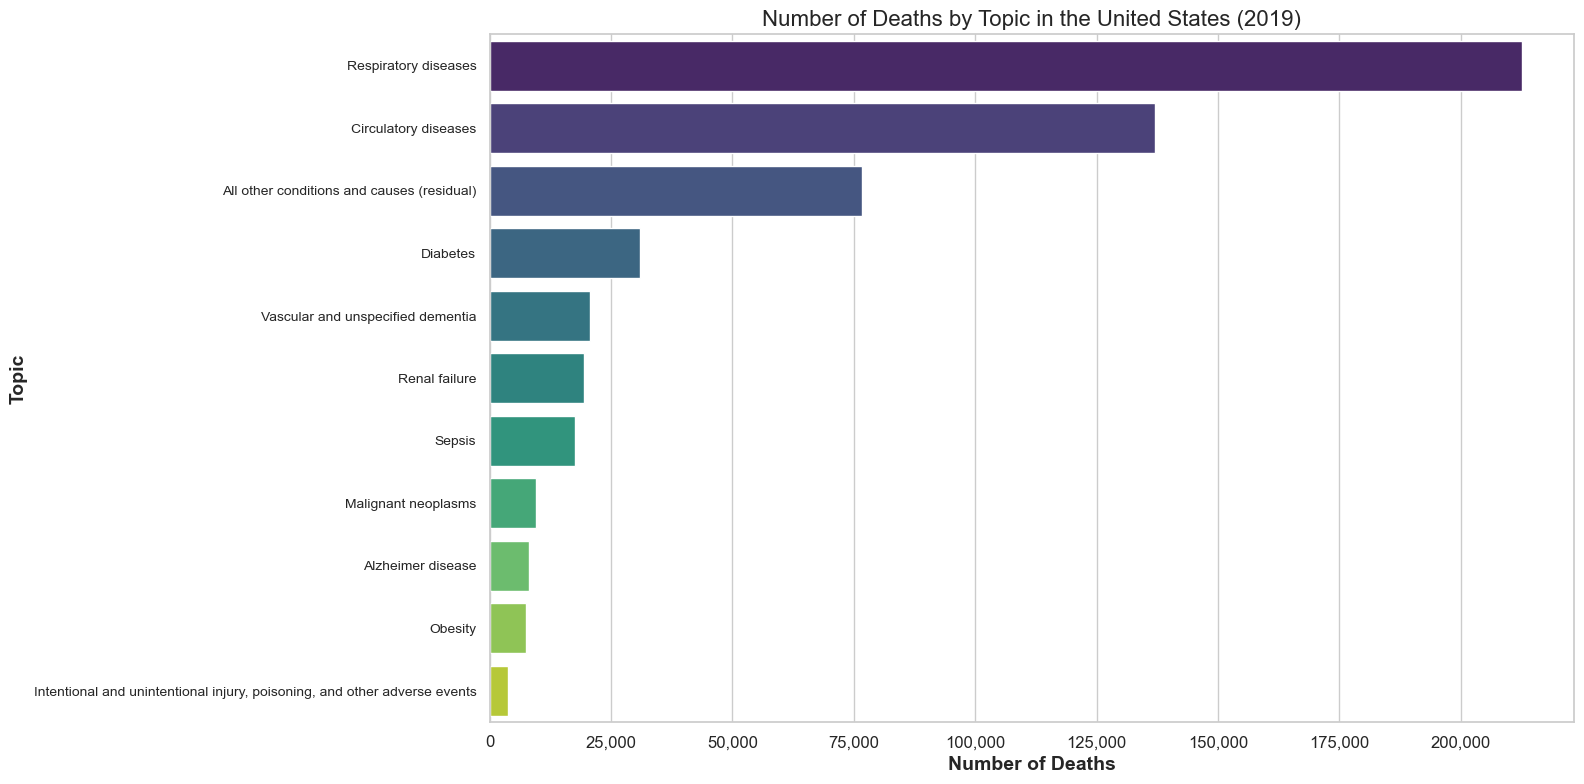

In [13]:
filtered_data = merged_df[
    (merged_df["State"] == "United States")
    & (merged_df["Year"] == 2020)
    & (merged_df["Topic"] != "COVID-19")
]

deaths_by_topic = filtered_data.groupby("Topic")["COVID-19 Deaths"].sum().reset_index()

deaths_by_topic = deaths_by_topic.sort_values(by="COVID-19 Deaths", ascending=False)

plt.figure(figsize=(16, 8))  # Increased the width of the plot
sns.barplot(data=deaths_by_topic, x="COVID-19 Deaths", y="Topic", palette="viridis")
plt.title("Number of Deaths by Topic in the United States (2019)", fontsize=16)
plt.xlabel("Number of Deaths", fontsize=14)
plt.ylabel("Topic", fontsize=14)

plt.xticks(fontsize=12)
plt.yticks(fontsize=10)  # Reduced the font size for topics

ax = plt.gca()
ax.xaxis.set_major_formatter(ticker.FuncFormatter(lambda x, _: f"{int(x):,}"))

plt.tight_layout()
plt.show()

The bar plot depicts the causes of death in the United States for the year 2019. It can
be seen that the major causes of mortality were respiratory diseases and circulatory diseases,
followed by all other conditions and causes. Other significant contributors were diabetes, vascular
and unspecified dementia, renal failure, sepsis, and malignant neoplasms, though their contribution
was much lower. 

### 2. Number of Deaths by Topic (category) in the United States (2021)

/var/folders/_d/ncq1_ycx743dwrbgqss9z7hr0000gn/T/ipykernel_6234/556378281.py:10: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `y` variable to `hue` and set `legend=False` for the same effect.

  sns.barplot(data=deaths_by_topic, x="COVID-19 Deaths", y="Topic", palette="viridis")


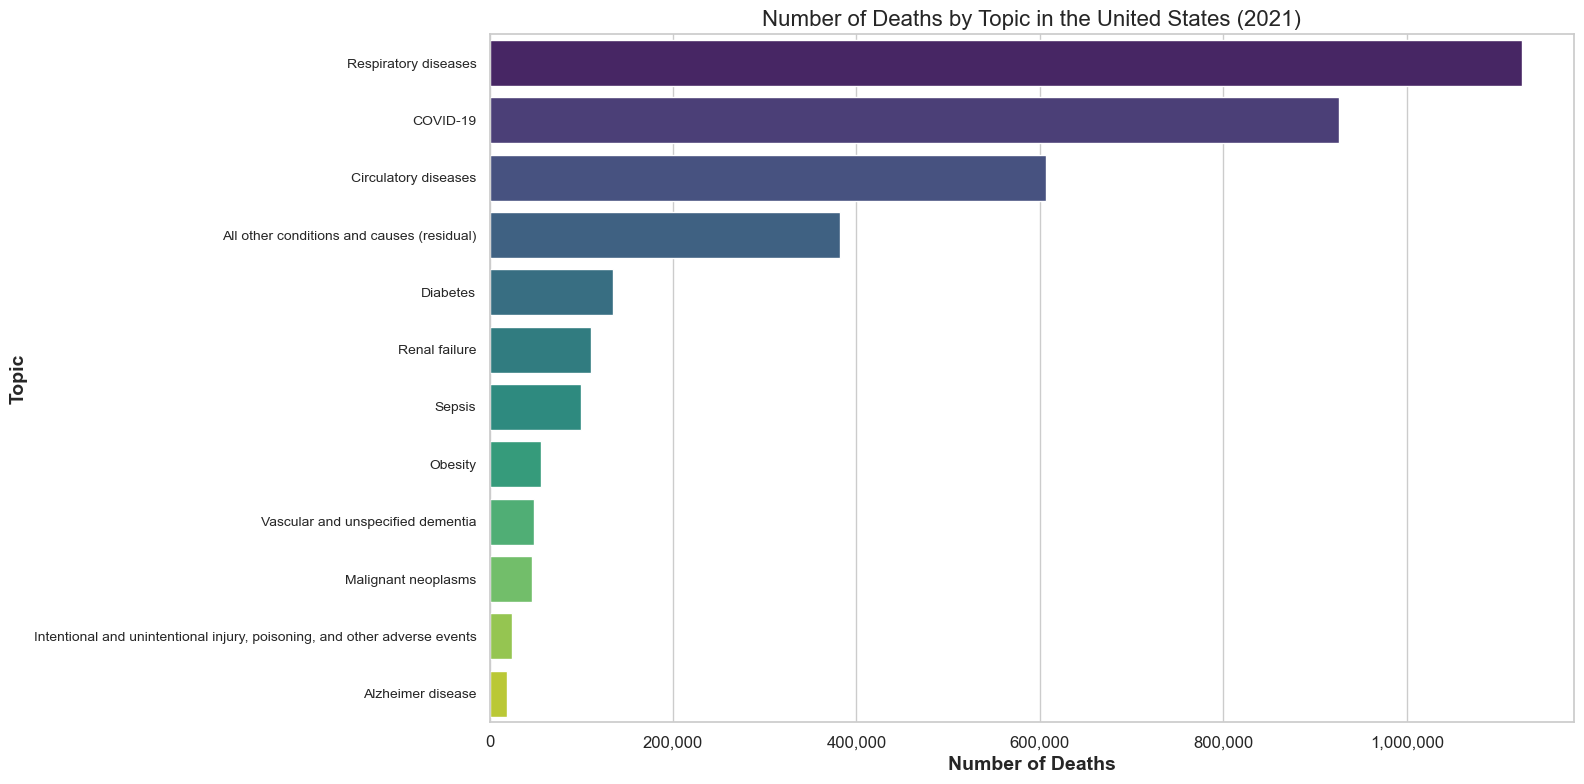

In [14]:
filtered_data = merged_df[
    (merged_df["State"] == "United States") & (merged_df["Year"] == 2021)
]

deaths_by_topic = filtered_data.groupby("Topic")["COVID-19 Deaths"].sum().reset_index()

deaths_by_topic = deaths_by_topic.sort_values(by="COVID-19 Deaths", ascending=False)

plt.figure(figsize=(16, 8))  # Increased the width of the plot
sns.barplot(data=deaths_by_topic, x="COVID-19 Deaths", y="Topic", palette="viridis")
plt.title("Number of Deaths by Topic in the United States (2021)", fontsize=16)
plt.xlabel("Number of Deaths", fontsize=14)
plt.ylabel("Topic", fontsize=14)

plt.xticks(fontsize=12)
plt.yticks(fontsize=10)  # Reduced the font size for topics

ax = plt.gca()
ax.xaxis.set_major_formatter(ticker.FuncFormatter(lambda x, _: f"{int(x):,}"))

plt.tight_layout()
plt.show()

The same bar plot using 2021 data puts the severity of COVID-19 into perspective. COVID-19 alone caused almost the same amount of death as the full category of respiratory diseases, which includes among other things: Chronic Obstructive Pulmonary Disease, Bronchitis, Asthma, Pneumonia, and Influenza. This is even more damning when you realize that most COVID-19 deaths are also related to respiratory disease deaths, and that the total count of respiratory disease deaths increased from 200,000 to almost 1,200,000 – a five-fold increase. It can also be seen that the death count for all other causes also increased, highlighting the impact of COVID-19 on the public healthcare system and our general health. These 2 plots above serve as our introduction to the project. First, we highlight the immediate impact of COVID-19. Next, we will give a brief overview of the current literature into the long-term impacts of COVID-19 before finally showing the results of our analysis.

### 3. COVID-19 Mortality Curve

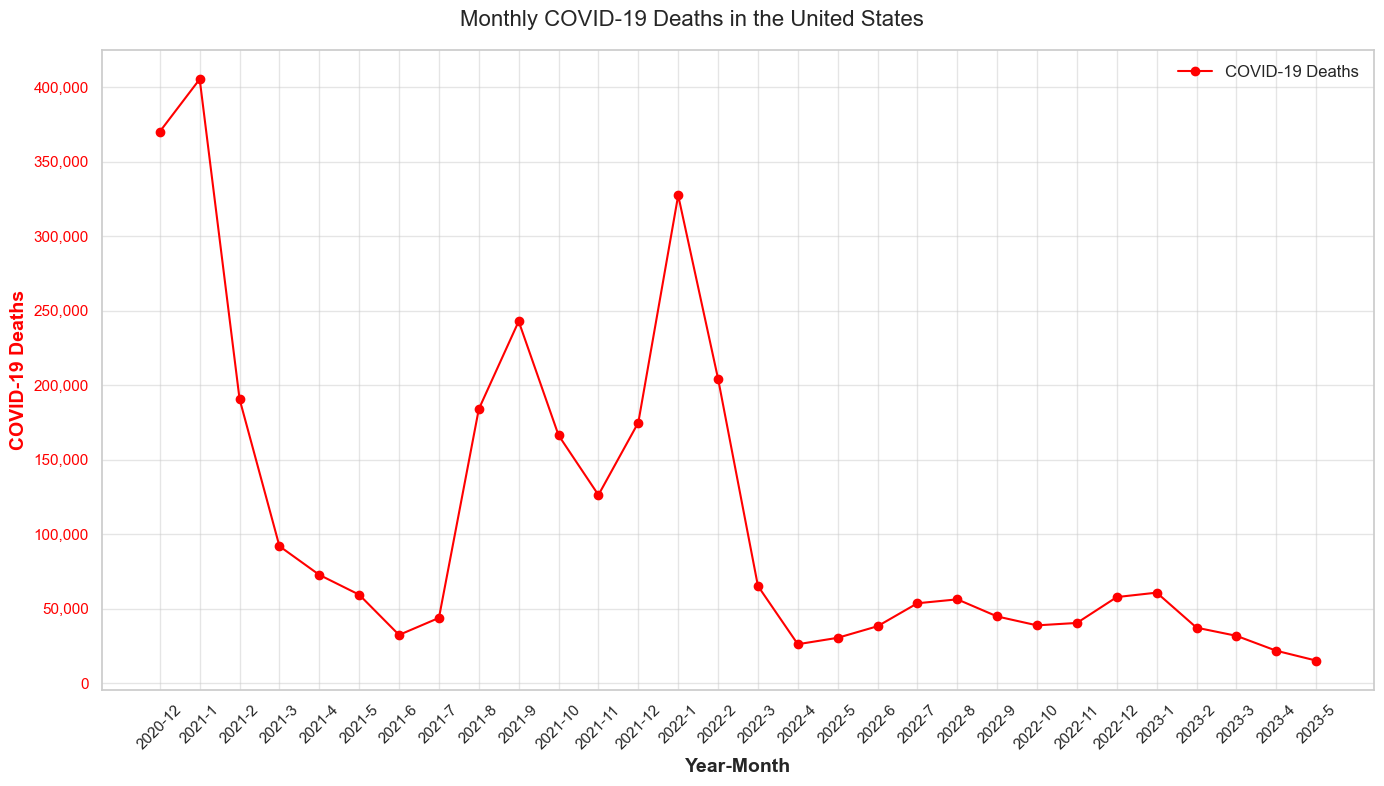

In [15]:
filtered_data = merged_df[
    (merged_df["State"] == "United States") & (merged_df["Age Group"] == "All Ages")
]

grouped_data = filtered_data.groupby(["Year", "Month"], as_index=False).agg(
    {
        "COVID-19 Deaths": "sum",  # Sum COVID-19 deaths for the same Year and Month
    }
)

grouped_data["Year-Month"] = (
    grouped_data["Year"].astype(str) + "-" + grouped_data["Month"].astype(str)
)

fig, ax1 = plt.subplots(figsize=(14, 8))

color = "red"
ax1.set_xlabel("Year-Month", fontsize=14)
ax1.set_ylabel("COVID-19 Deaths", color=color, fontsize=14)
ax1.plot(
    grouped_data["Year-Month"],
    grouped_data["COVID-19 Deaths"],
    marker="o",
    label="COVID-19 Deaths",
    color=color,
)
ax1.tick_params(axis="y", labelcolor=color)
ax1.tick_params(axis="x", rotation=45)

# Add gridlines for better readability
ax1.grid(alpha=0.5)

# Use formatter to avoid scientific notation on the y-axis
ax1.yaxis.set_major_formatter(FuncFormatter(lambda x, _: f"{int(x):,}"))


# Add title and legend
fig.suptitle("Monthly COVID-19 Deaths in the United States", fontsize=16)
ax1.legend(loc="upper right", fontsize=12)

fig.tight_layout()  # Prevent overlap of elements
plt.show()

Here we will go on a little tangent and provide the background for our methodology. This is a plot showing the COVID-19 mortality curve. But how do we know that this count is accurate? 

This is in fact the same question that Hank Green (of the Crash Course fame and brother to the author John Green) and Joss Fong (an award winning journalist from Vox) tried to answer in their video titled [“How accurate is the Covid death count?”](https://www.youtube.com/watch?v=JS2rCjvjYLU)). Together with Shira Doron, MD (an epidemiologist from Tufts Medical Center) and Sondre Ulvund Solstad, PhD (another award winning journalist from The Economist), they decided to explore the excess mortality count. 

They explained that all official COVID-19 death counts come from death certificates. In death certificates, there is a section called the underlying cause of death, where you are able to put the immediate cause of death and under it you can put the underlying cause to that cause (e.g., immediate cause: brain hemorrhage -> underlying cause: severe head trauma -> underlying cause: motor vehicle accident). If COVID-19 appears anywhere in this chain, it will be counted as a COVID-19 death. However, since this is a manual process, there are suspicions that the true death toll of COVID-19 is higher. 

The excess mortality approach relies on the fact that death rates do not change much year-over-year. Under normal circumstances, the death rate for this year will not be twice as high as the death rate of last year. With this, they are able to ignore the COVID-19 count from the underlying cause of death and just take a look at the differences between predicted death count and actual death count, then compare it with the reported COVID-19 count. They found that in the U.S., we are likely undercounting the true death toll by about 200,000 (global death toll is a separate discussion, many countries’ vitality monitoring systems are not as robust as the U.S.).

![excess mortality](images/hw9/excess_mortality.jpeg)
Credit: The Economist, Joss Fong

In this project, we will explore the claims of the long-term effects of COVID-19 in a similar manner; by creating predictions using pre-covid data and comparing it with the true post-covid data. 

Our predictions will be generated using two methods: splines and time series forecasting using Meta’s Prophet Forecasting Model (original paper: [“Forecasting at Scale”](https://peerj.com/preprints/3190.pdf)). For data with few pre-covid data points such as the disability data, splines will be used. For data with more data points the Prophet model will be used. There’s no exact cut-off; the model used in the final version of the plots is chosen based on visual assessment of the fit, but it’s generally around ~5 data points (i.e., 5 years). The spline parameters are automatically adjusted based on the number of data points, with constraints to prevent overfitting, but it is either a quadratic (degree=2) or cubic (degree=3) spline with a maximum of n/2 knots. The Prophet model is fitted with default parameters.

### 4 - 11. Chronic Health Indicators

Note: After HW9 was submitted, COPD and both Asthmas were combined into one plot under the topic "Respiratory Diseases". Both cancers were also combined into one plot under the topic "Cancer". Code below reflects the update. Descriptions are in separate subsections.

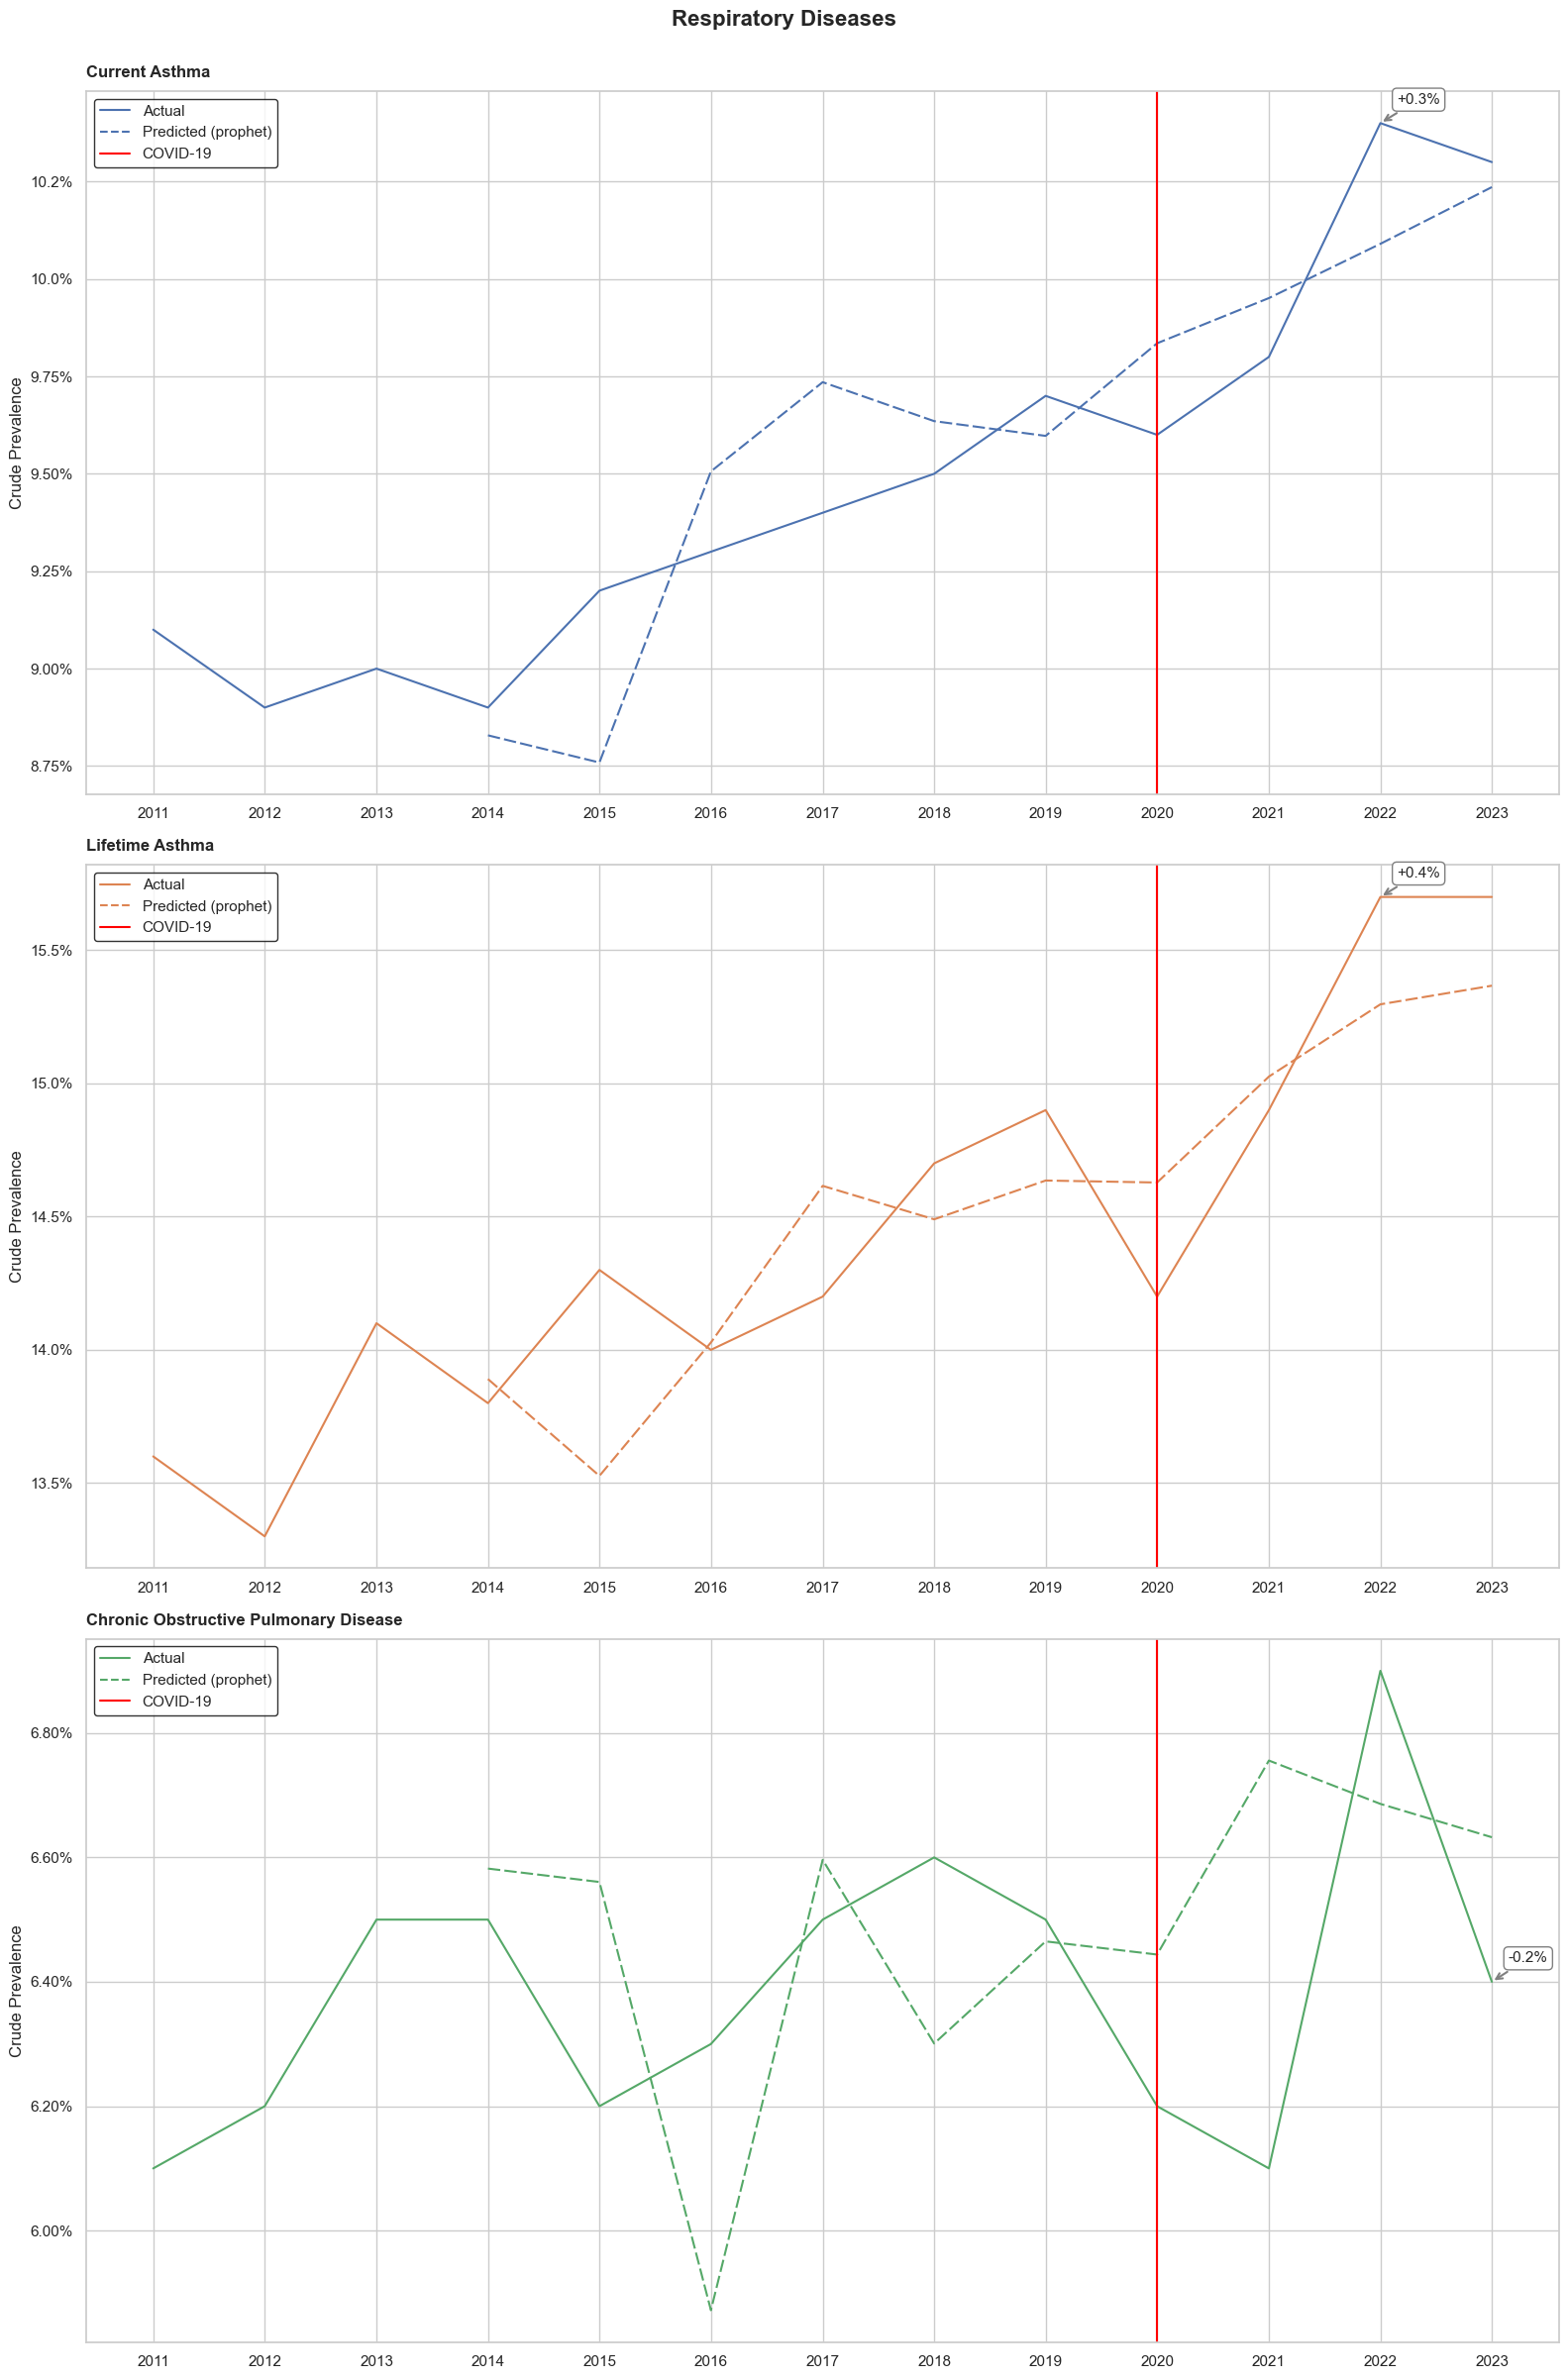

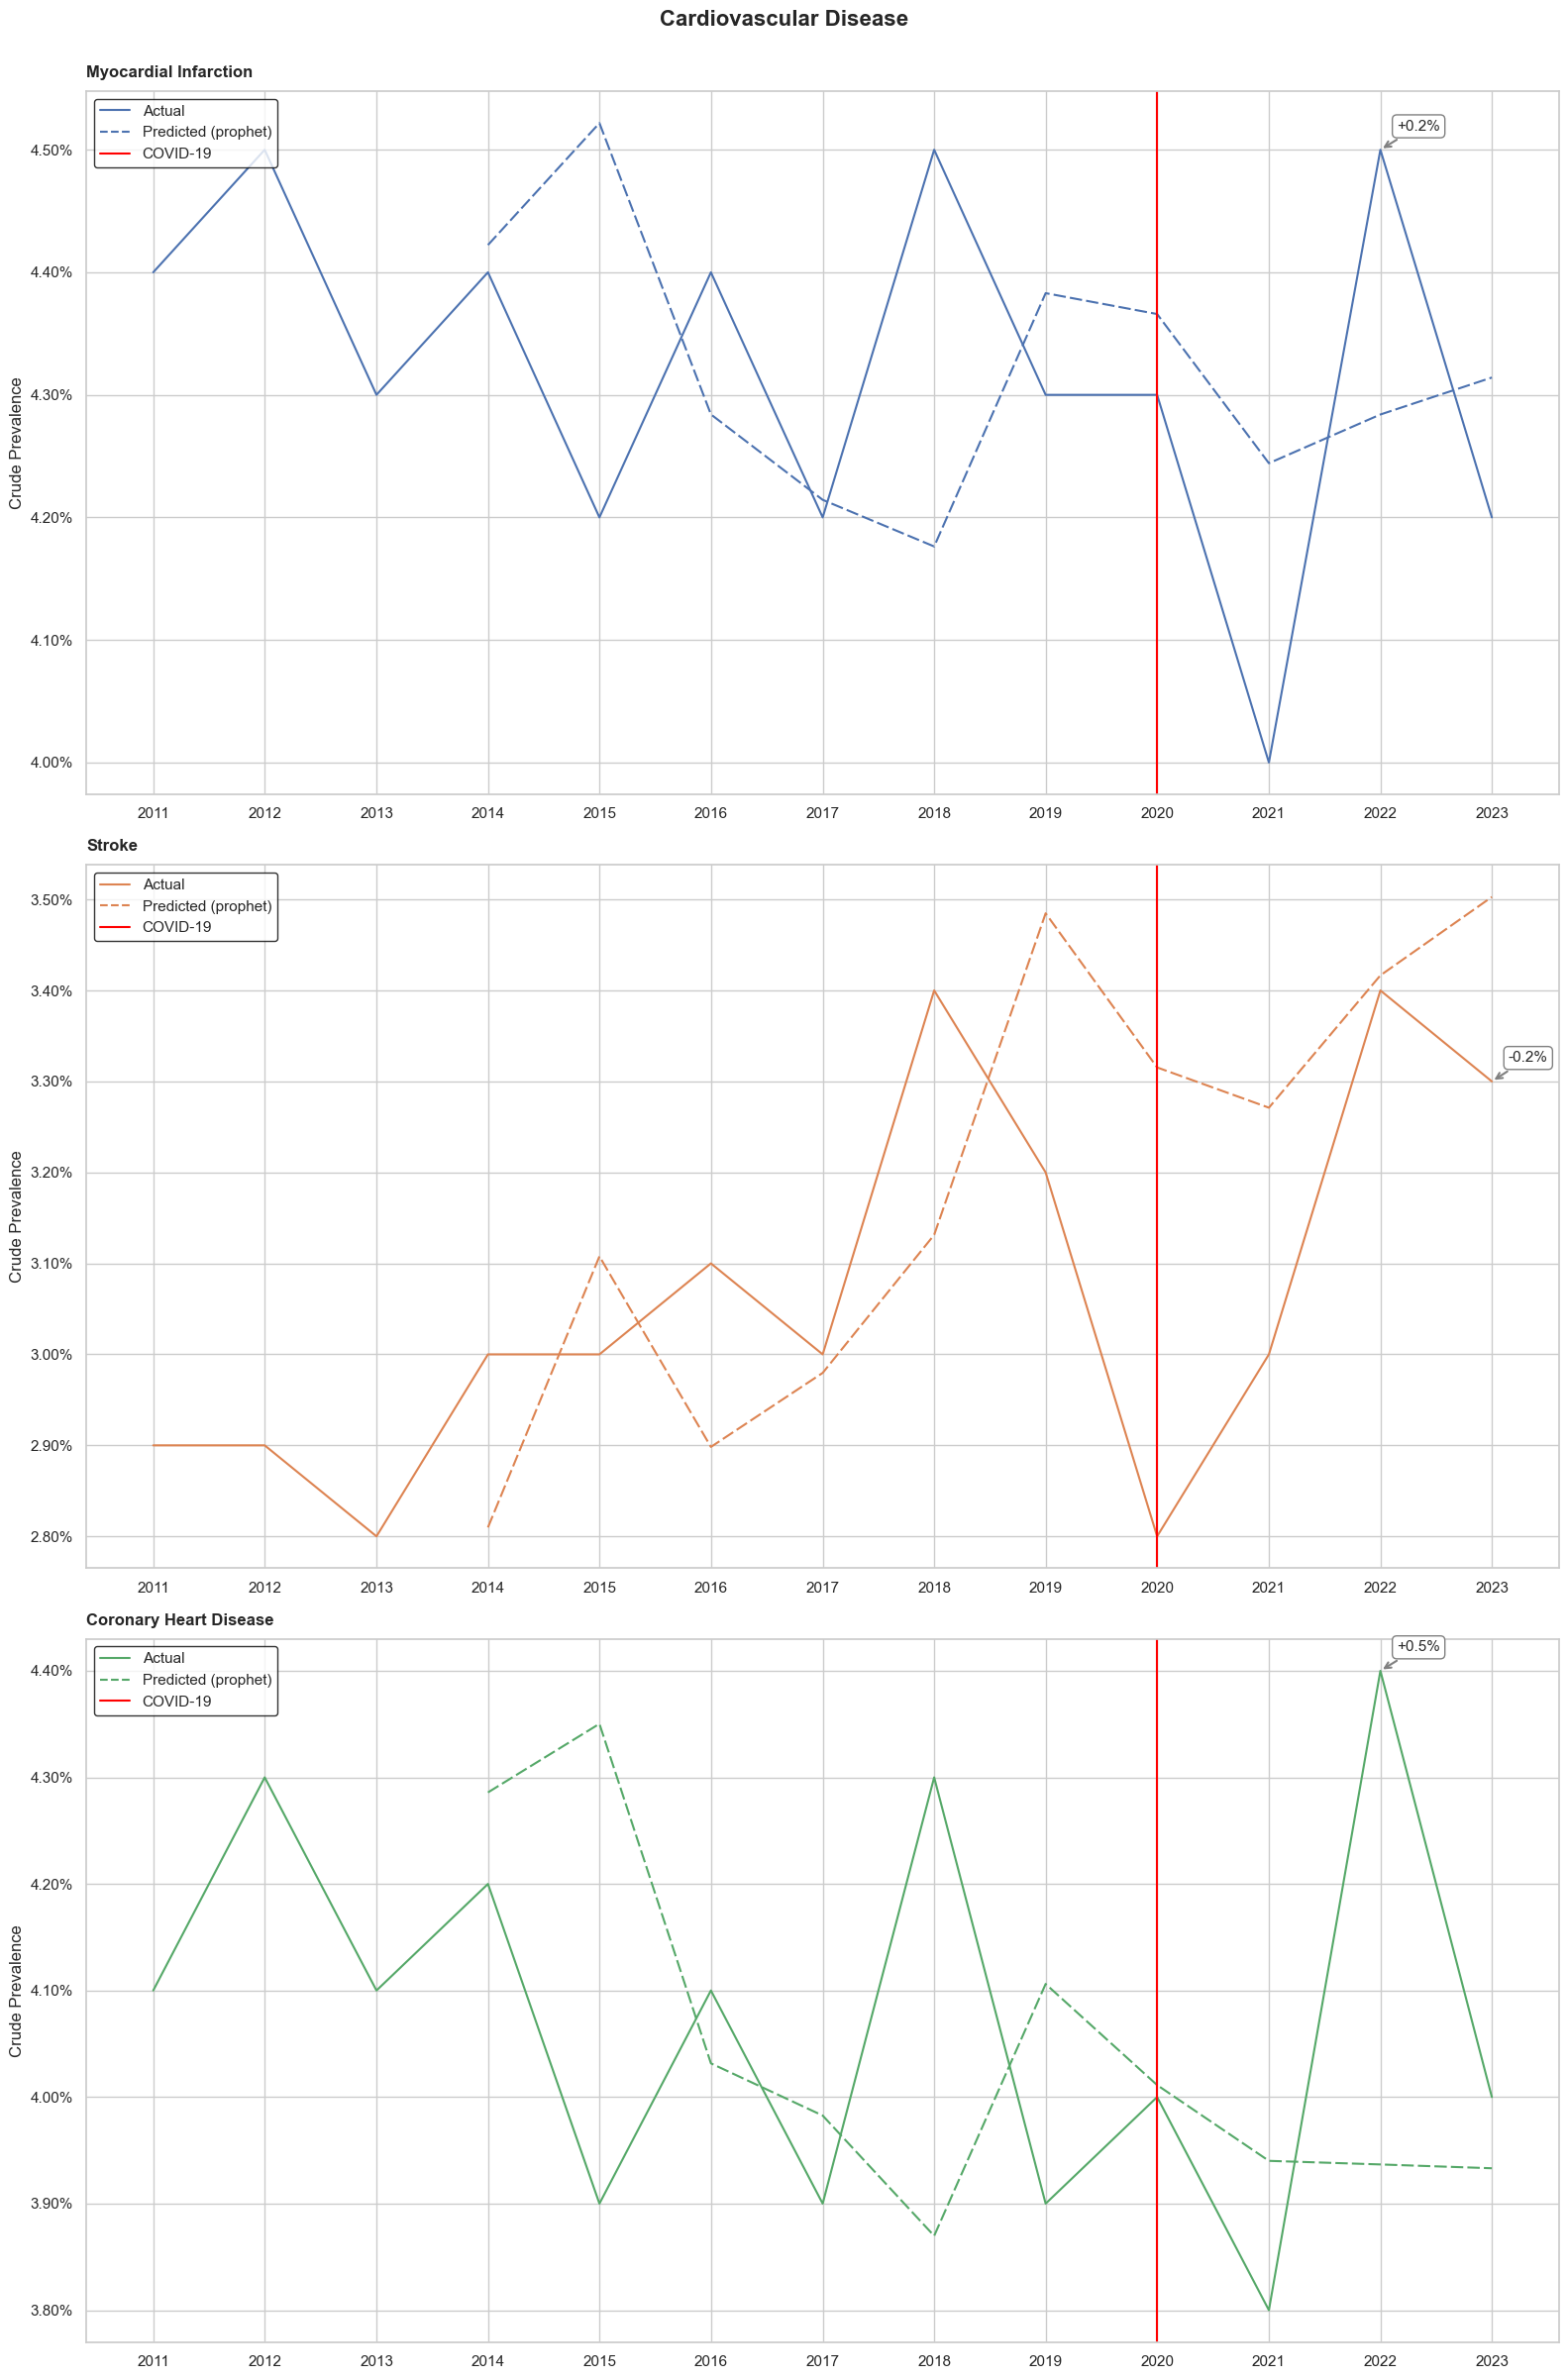

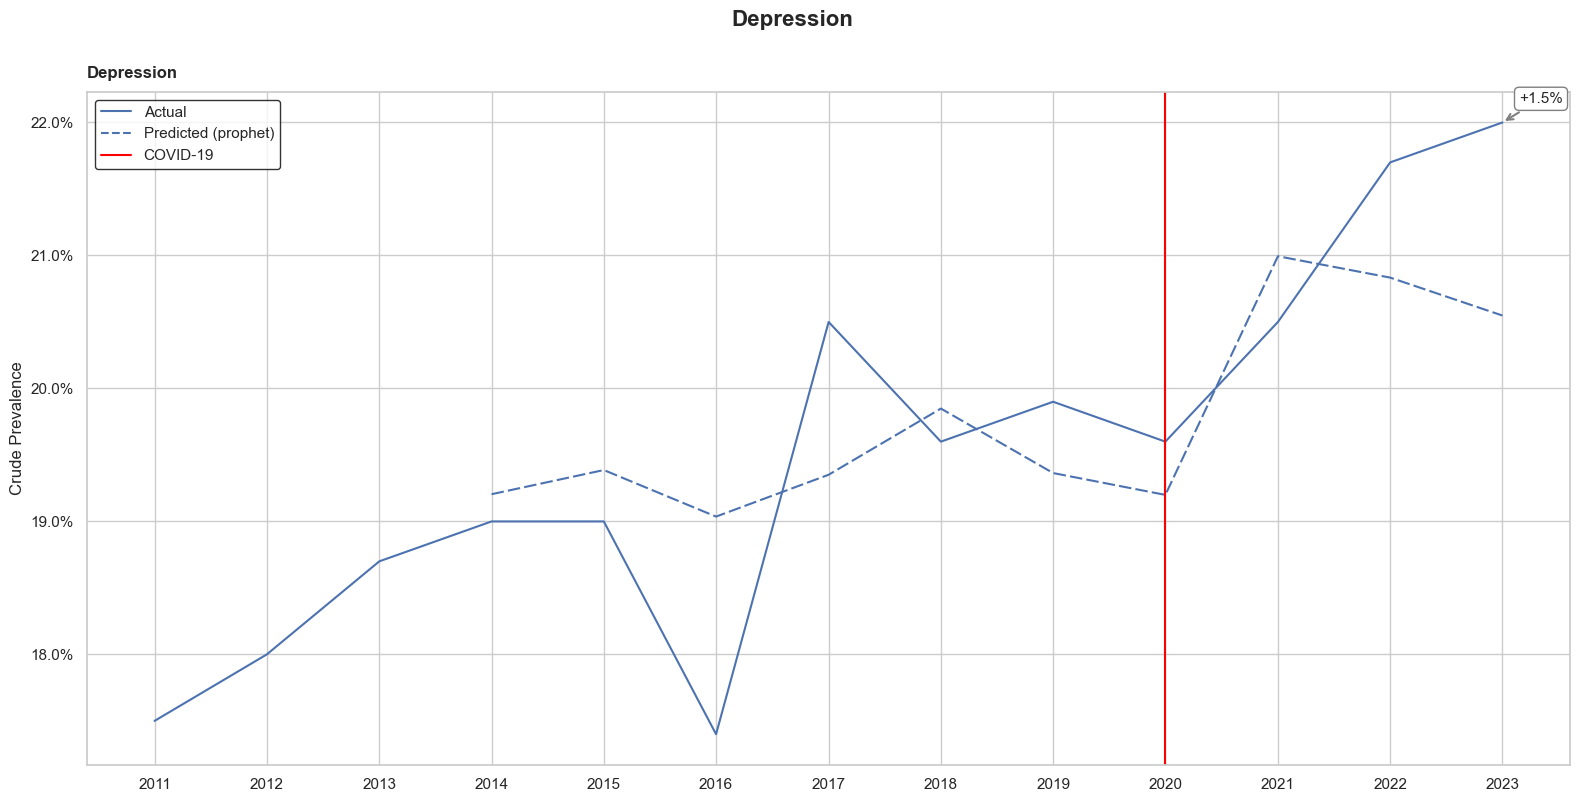

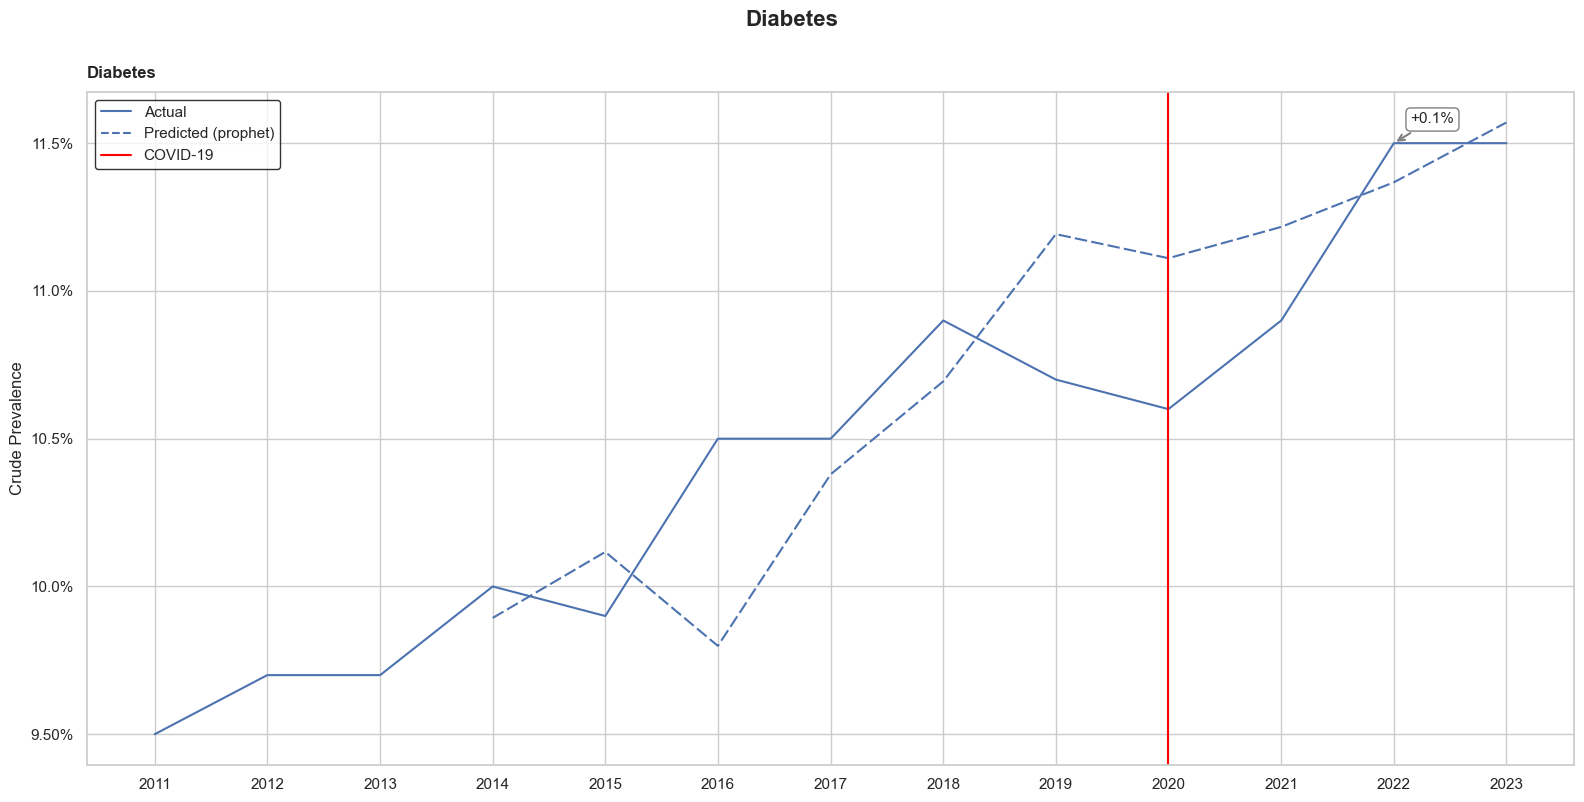

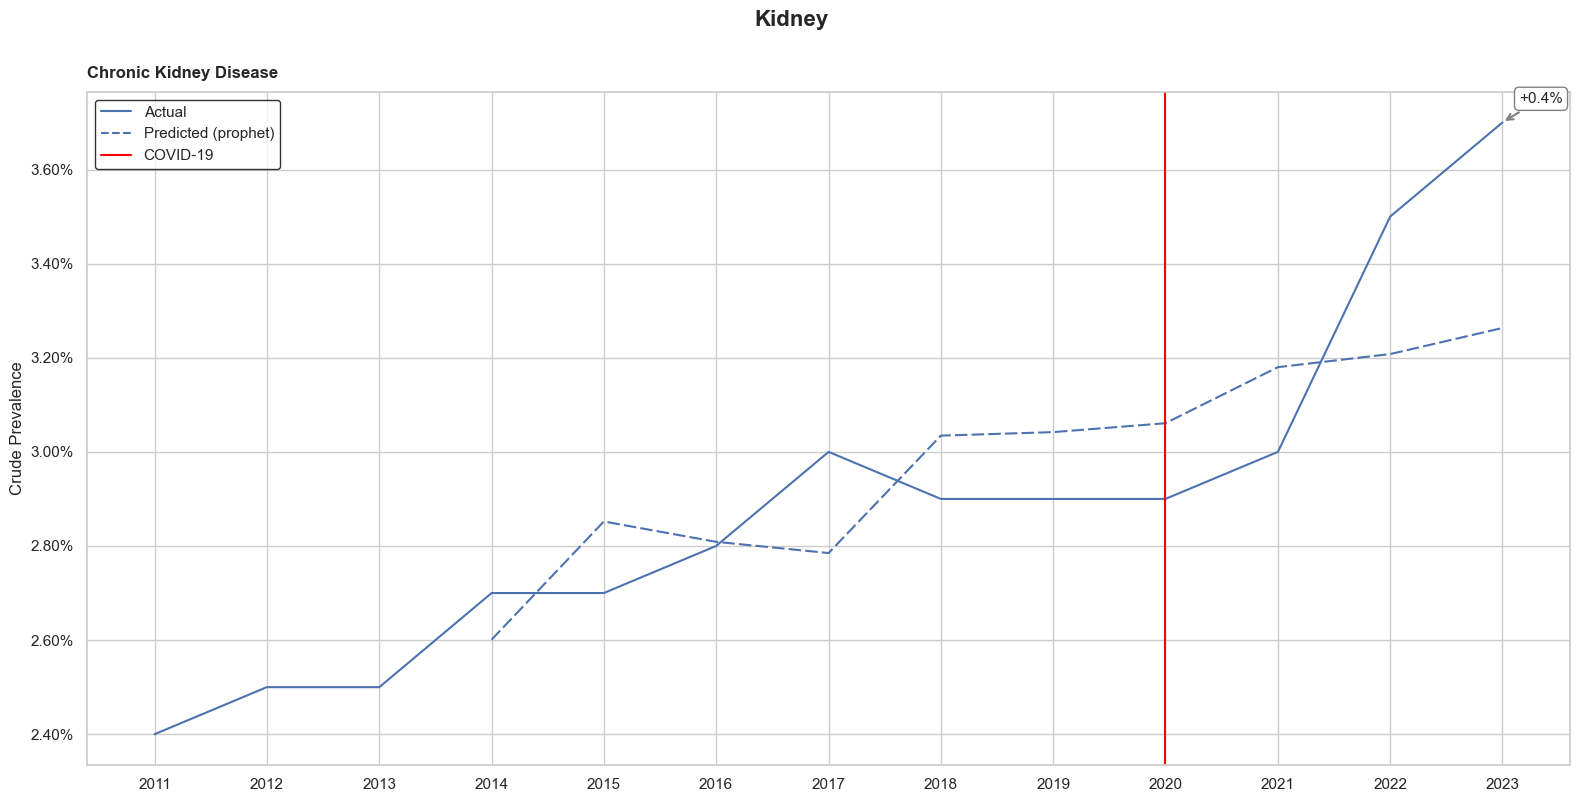

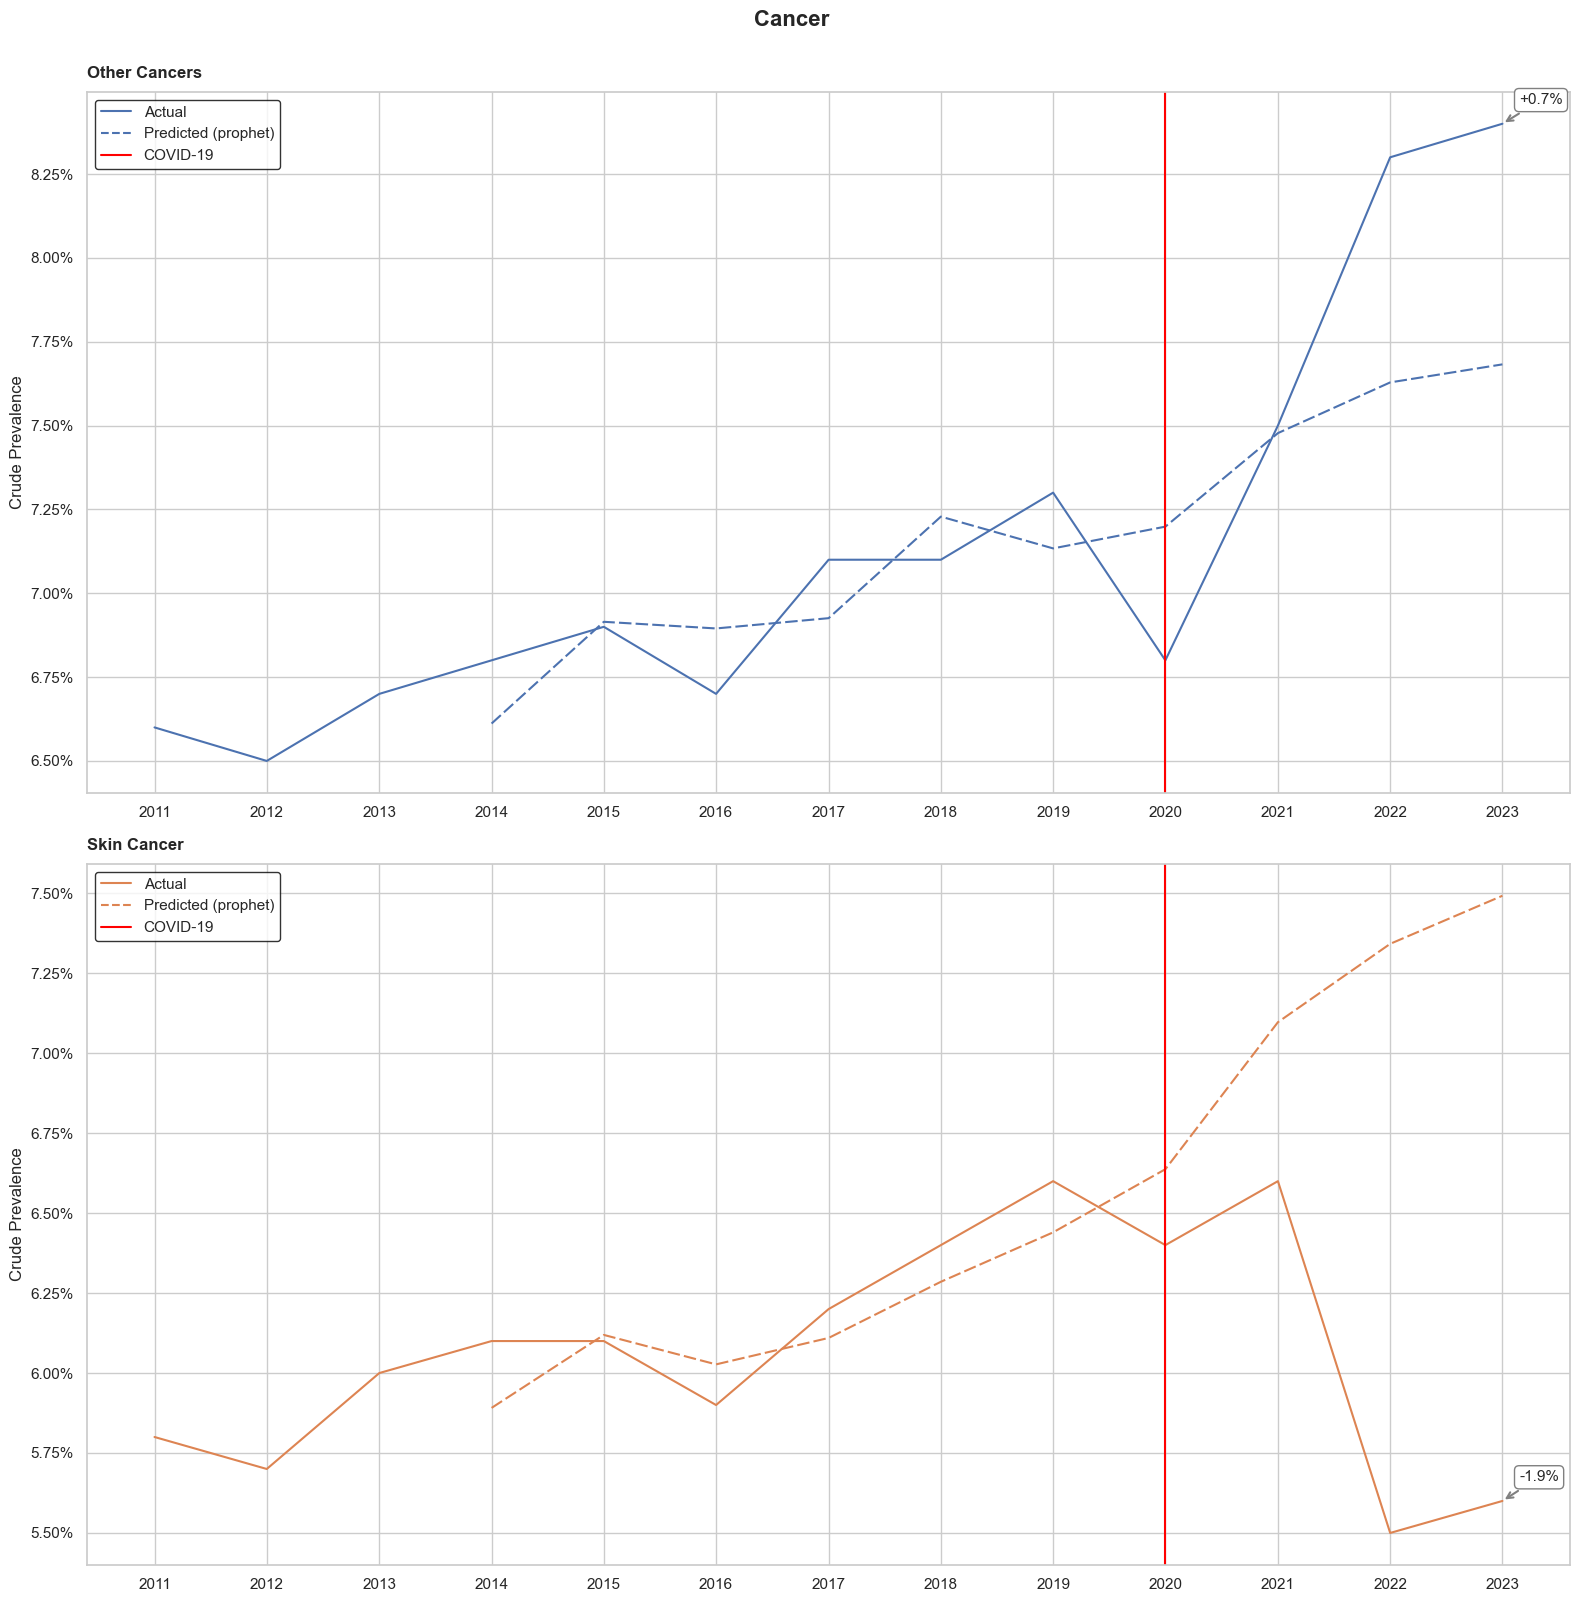

In [16]:
plot_forecast_comparison(brfss_df, method="prophet", only_post=False)

#### 4. Topic 1: Asthma

Though there is no evidence that Asthma increases risk of a COVID-19 infection (source: [AAAAI](https://www.aaaai.org/tools-for-the-public/conditions-library/asthma/covid-prevent)), there is evidence that a COVID-19 infection increases the risk of developing Asthma (source: [JACI](https://www.jaci-inpractice.org/article/S2213-2198(23)01047-4/fulltext)). Here we see that asthma rates are at an all time high for both people with current asthma and for people who have ever had asthma in the past. Both are slightly above expected values.

#### 5. Topic 2: Chronic Obstructive Pulmonary Disease (COPD)

 COPD is a disease characterized by damaged airways, lung tissue, and air sacs in the lungs and is primarily caused by tobacco use (“about 75 percent of all COPD cases occur in people with a history of smoking” - [American Lung Association](https://www.lung.org/lung-health-diseases/lung-disease-lookup/copd/what-causes-copd)). Though there are many evidence of worse health outcomes in persons with both COPD and a COVID-19 infection (source: [1](https://pmc.ncbi.nlm.nih.gov/articles/PMC8815646/), [2](https://www.thelancet.com/journals/eclinm/article/piis2589-5370(21)00069-9/fulltext)), we were not able to find reliable literature related to the causal link between COVID-19 and COPD. Here our plot shows no correlation, though it is quite noisy.

#### 6. Topic 3: Cardiovascular Disease (Myocardial Infarction/Heart Attack, Stroke, Coronary Heart Disease)

There are many reports of COVID-19 causing lasting heart damage (see sources in our intro above, e.g., [American Heart Association](https://www.heart.org/en/news/2024/01/16/how-covid-19-affects-your-heart-brain-and-other-organs)). Here our plot shows a slight increase above expected values for Myocardial Infarction and (especially) Coronary Heart Disease. It seems we are at an all-time high for Coronary Heart Disease. Keep in mind that the percent change labeled in the plot is the absolute magnitude of the change. Relatively, an increase of 0.5% over ~4% is a 12% increase.

#### 7. Topic 4: Depression

Due to COVID-19’s effects on the brain, there are many reports of significant increases in brain-related symptoms long after the initial infection (source: [Yale](https://www.yalemedicine.org/news/depression-and-anxiety-in-long-covid-why-interdisciplinary-treatment-is-needed)) – of which Depression is one. Here our plots shows that depression is at an all-time high amongst the general population and sees a very sizable increase over predicted values.


#### 8. Topic 5: Diabetes

There is extremely strong evidence that COVID-19 increases the risk for new-onset (type 2) diabetes (source: [Cedars-Sinai Medical Center](https://www.cedars-sinai.org/newsroom/verified-covid-19-infection-increases-diabetes-risk/)). Our plot shows a slight increase over predicted values, though we are now at an all-time high for the prevalence of any type of diabetes. It is to be noted that the prevalence of diabetes has been consistently rising over time, which combined with our limited data caused our model to predict much higher values than actual, even during pre-covid era in 2019. 

#### 9. Topic 6: Chronic Kidney Disease (CKD)

 There were many reports of COVID-19 causing an increase in the risk of developing CKD (source: Nature). A recent report from Yale confirmed the increase, but added that “even though there was a steep decline in kidney function in the COVID patients during the first six months after hospitalization, those with COVID-associated AKI [Acute Kidney Injury] had a significantly lower risk of major adverse kidney events and mortality over the longer term compared to those with AKI related to other causes”. Our plot shows a substantial increase over predicted values, and also that the prevalence of CKD is now at an all-time high.

#### 10. Topic 7: Other (non-skin) Cancers

The literature on the causal link between COVID-19 and cancer is mixed. There are some that report “long COVID‐19 may predispose recovered patients to cancer development and accelerate cancer progression” (source: [Georgia State University](https://pmc.ncbi.nlm.nih.gov/articles/PMC8206711/)) along with general cancer-causing capacity of COVID-19 (source: [Biochimie Journal](https://pmc.ncbi.nlm.nih.gov/articles/PMC10202899/)). And yet, there are others who report that COVID-19 might be some kind of “anti-cancer” (source: [Time](https://time.com/7176558/covid-19-virus-cancer-monocytes/), [International Journal of Oncology](https://pmc.ncbi.nlm.nih.gov/articles/PMC8923649/)). Our plot shows a significant increase in Cancer prevalence over expected values. Future work may include a deeper dive into the specific types of cancer behind this increase.

#### 11. Topic 8: Skin Cancer

This one is to be included in our presentation (though not necessarily the report) for humour purposes. This is one of the largest gaps between expected and actual values in our analysis. We hypothesize that skin cancer rates are much lower because people have spent much more time indoors post-covid. 

### 12. Chronic Health Indicators Summary

TODO: Double-check the legend calculation

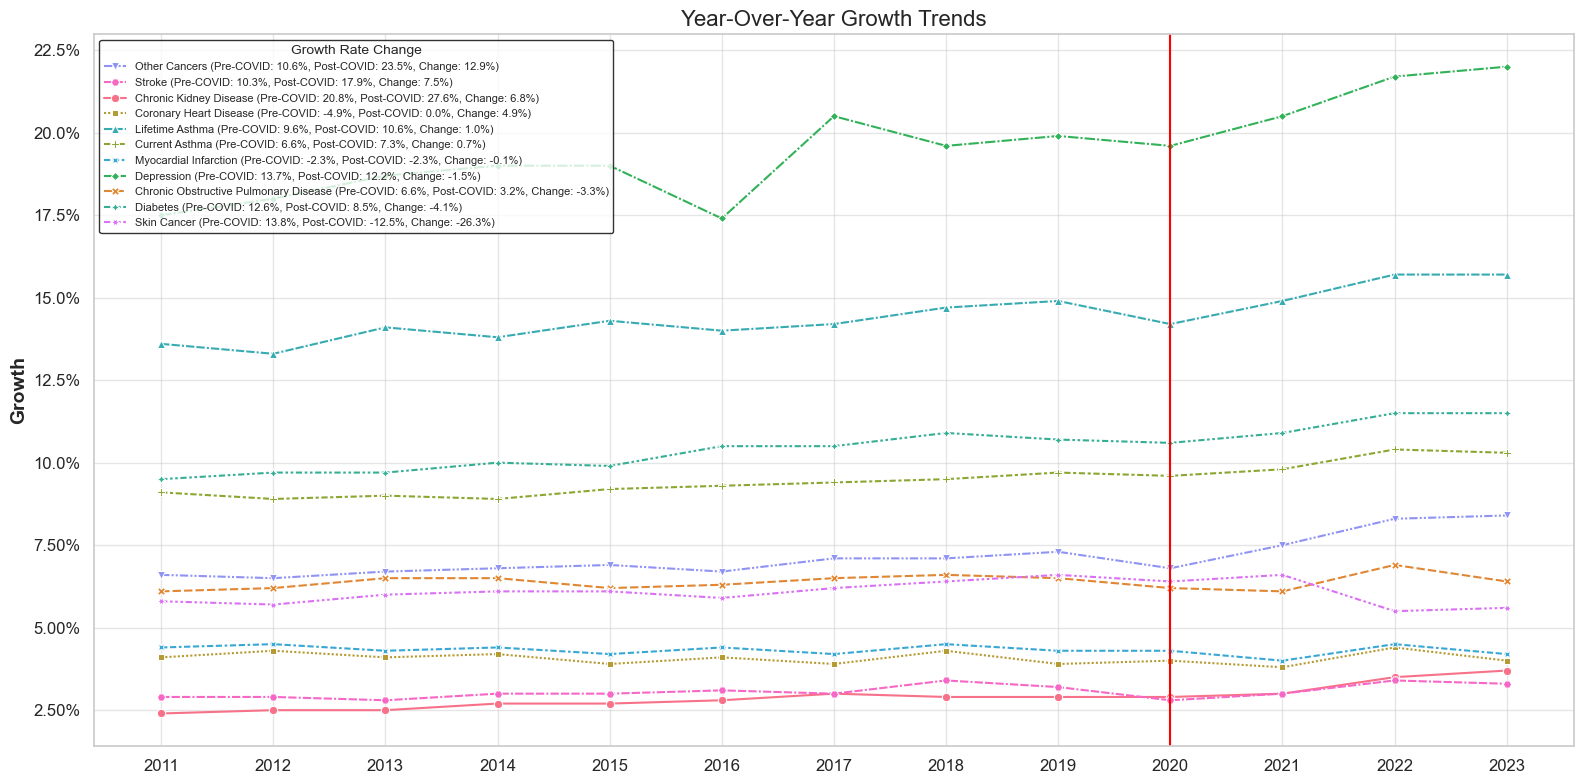

In [17]:
plot_year_over_year_growth(brfss_df)

Here we plot the year-over-year growth % change for all of the topics covered previously – collectively termed “chronic health indicators”. The legend is sorted by largest change at the top. The “topic” that sees the most relative change is “Other (Non-Skin) Cancers”, followed by Stroke, Chronic Kidney Disease, Coronary Heart Disease, and others.

### 13. Percentage of Disabled People in the US in 2019

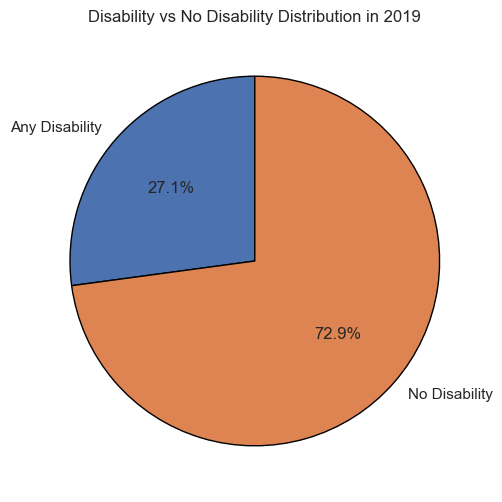

In [18]:
disability_people = disability_df[
    (disability_df["Year"] == "2019")
    & (disability_df["Question"].isin(["Any Disability", "No Disability"]))
]

data_summary = disability_people.groupby("Question")["DataValue"].sum()

plt.figure(figsize=(6, 6))
plt.pie(
    data_summary,
    labels=data_summary.index,
    autopct="%1.1f%%",
    startangle=90,
    wedgeprops={"edgecolor": "black"},
)
plt.title("Disability vs No Disability Distribution in 2019")
plt.show()

The pie chart visualizes the distribution of individuals with and without disabilities in the United States in 2019. It shows that: 27.1% of the population reported having any disability, while 72.9% of the population reported having no disability.
This graph provides a snapshot of disability prevalence prior to the COVID-19 pandemic, offering a baseline to compare changes in disability rates over time. With the long-term health effects of COVID-19, it becomes crucial to observe how these rates may have shifted in the years following the pandemic.

### 14. Breakdown of Disability in 2019

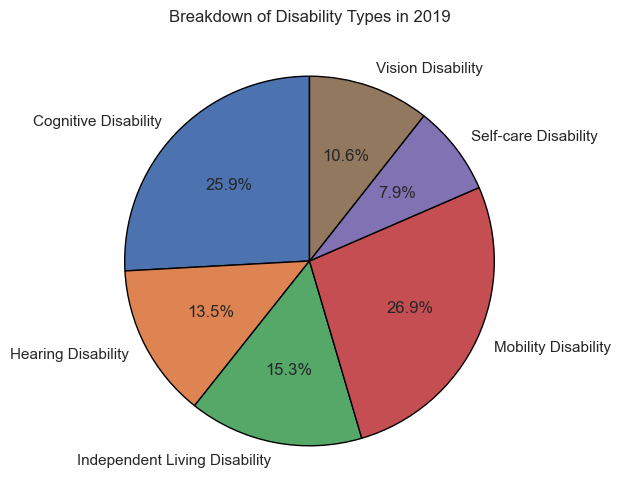

In [19]:
disabilities_2019 = disability_df[
    (disability_df["Year"] == "2019")
    & (~disability_df["Question"].isin(["Any Disability", "No Disability"]))
]

data_summary = disabilities_2019.groupby("Question")["DataValue"].sum()

plt.figure(figsize=(6, 6))
plt.pie(
    data_summary,
    labels=data_summary.index,
    autopct="%1.1f%%",
    startangle=90,
    wedgeprops={"edgecolor": "black"},
)
plt.title("Breakdown of Disability Types in 2019")
plt.show()

The pie chart shows the breakdown of disability types in 2019, illustrating the distribution of various disabilities within the population. The most common disabilities are related to mobility and cognitive functions, followed by other types such as hearing and independent living disabilities. This distribution provides insight into the prevalence of different disabilities and helps contextualize how factors like COVID-19 might impact these specific areas, potentially leading to changes in the overall disability landscape in the years following the pandemic.

### 15. Topic 9: Disability Estimates

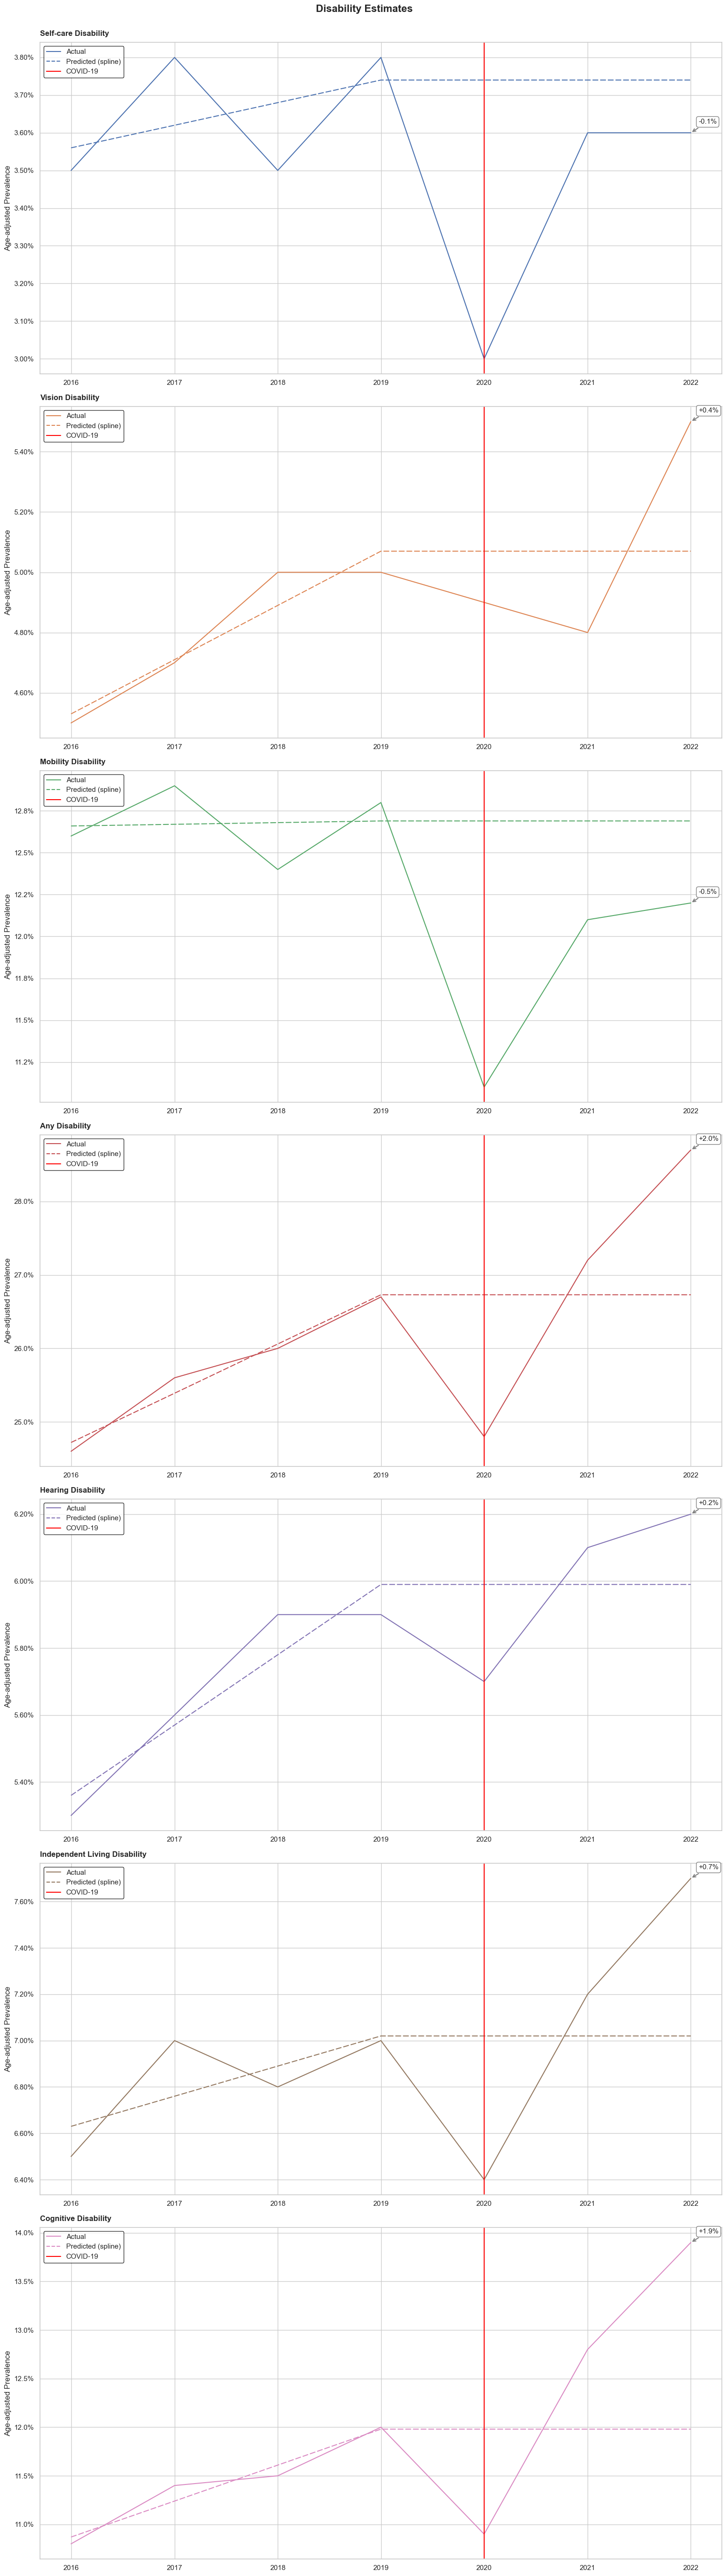

In [20]:
plot_forecast_comparison(disability_us_without_no_df, method="spline", only_post=False)

Here we take a close look at how various disability rates change throughout the years. We can see that the rate of “Any Disability” – an increase of 2% over expected values, equating to around 6 million people. This increase is mostly explained by an identical increase in the rates of “Cognitive Disability”. This tracks with our understanding of COVID-19. Do note that there are different levels of disability, with the most severe usually categorized as having significant difficulty or inability to do basic tasks in their daily lives; this usually accounts for around 10% in the U.S. (source: [NHIS](https://wwwn.cdc.gov/NHISDataQueryTool/SHS_adult/index.html))

### 16. Disability Breakdown Summary

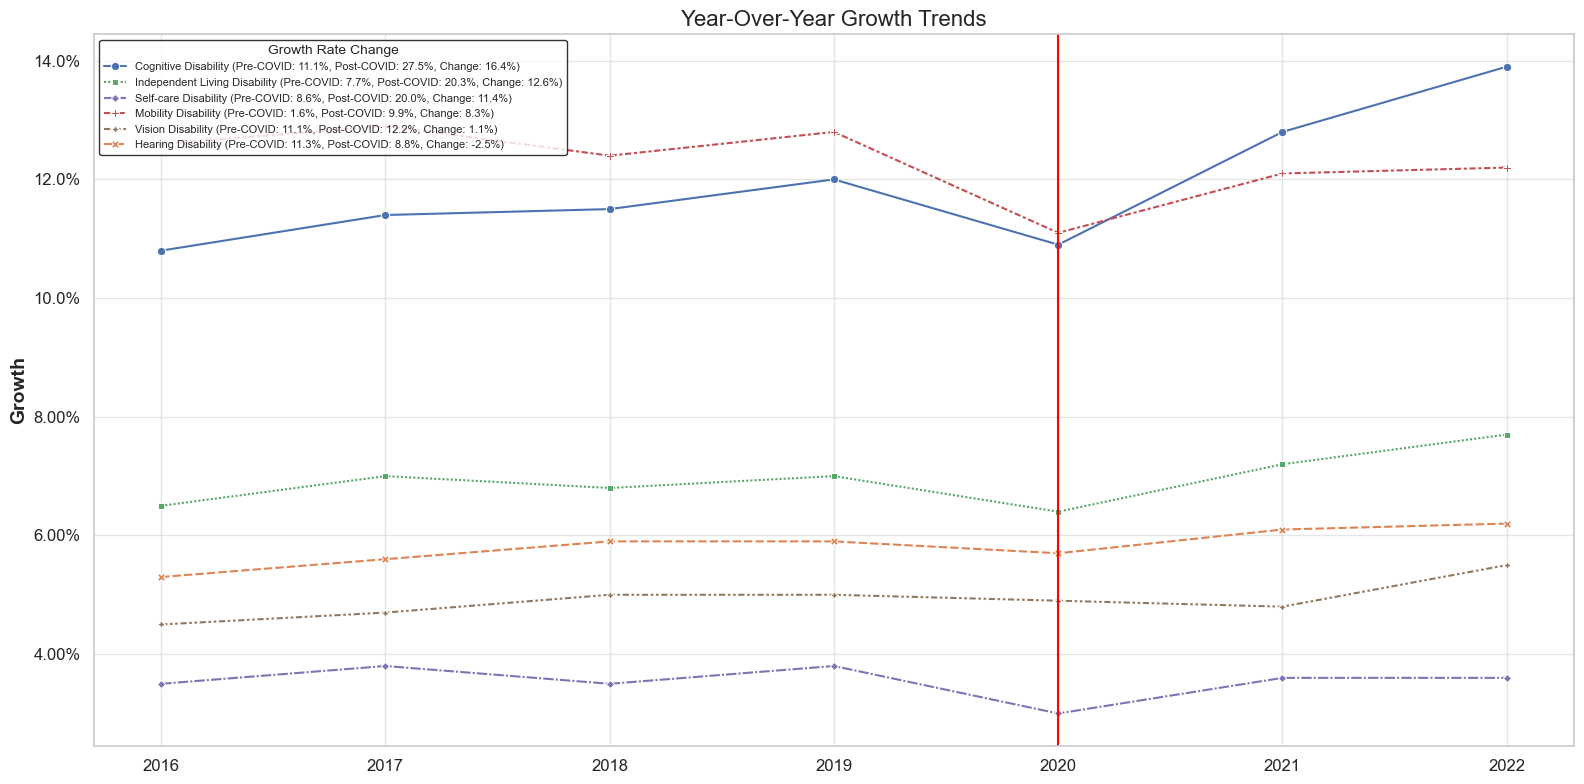

In [21]:
plot_year_over_year_growth(disability_us_breakdown_df)

Here we see that the biggest increases post-covid are cognitive disability, independent living disability, and self-care disability. Again, this tracks with our understanding.

### 17. Breakdown of Disability in 2022

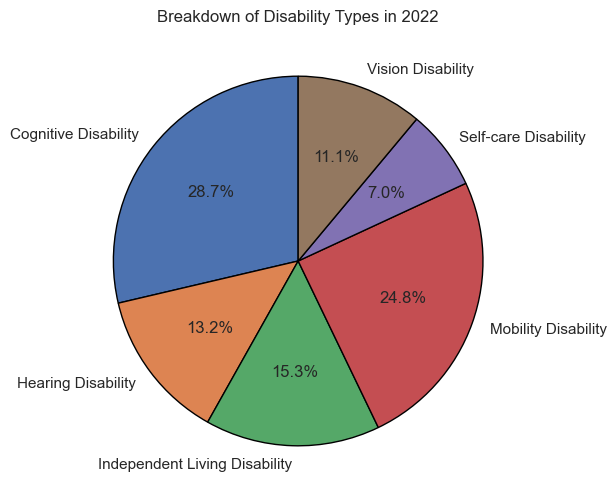

In [22]:
disabilities_2022 = disability_df[
    (disability_df["Year"] == "2022")
    & (~disability_df["Question"].isin(["Any Disability", "No Disability"]))
]

data_summary = disabilities_2022.groupby("Question")["DataValue"].sum()

plt.figure(figsize=(6, 6))
plt.pie(
    data_summary,
    labels=data_summary.index,
    autopct="%1.1f%%",
    startangle=90,
    wedgeprops={"edgecolor": "black"},
)
plt.title("Breakdown of Disability Types in 2022")
plt.show()

The proportion of disability changed slightly; Cognitive Disability is now the leading type of disability.

### 18. COVID-19 VS Vaccination Counts (Monthly)

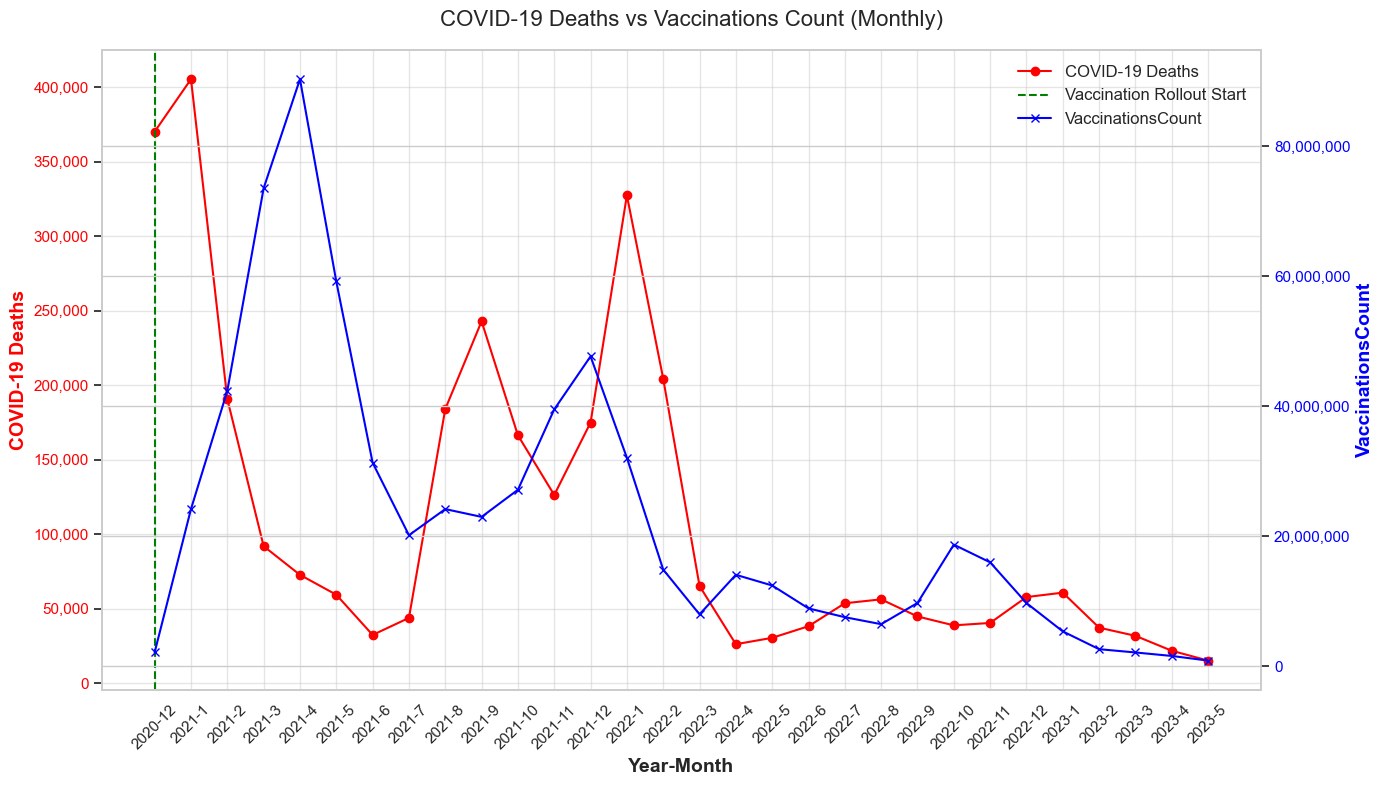

In [23]:
filtered_data = merged_df[
    (merged_df["State"] == "United States") & (merged_df["Age Group"] == "All Ages")
]

grouped_data = filtered_data.groupby(["Year", "Month"], as_index=False).agg(
    {
        "COVID-19 Deaths": "sum",  # Sum COVID-19 deaths for the same Year and Month
        "VaccinationsCount": "first",  # Take the first vaccination count for each group
    }
)


grouped_data["Year-Month"] = (
    grouped_data["Year"].astype(str) + "-" + grouped_data["Month"].astype(str)
)

# Plot the data with dual y-axes
fig, ax1 = plt.subplots(figsize=(14, 8))

# Plot COVID-19 Deaths on the first y-axis
color = "red"
ax1.set_xlabel("Year-Month", fontsize=14)
ax1.set_ylabel("COVID-19 Deaths", color=color, fontsize=14)
ax1.plot(
    grouped_data["Year-Month"],
    grouped_data["COVID-19 Deaths"],
    marker="o",
    label="COVID-19 Deaths",
    color=color,
)
ax1.tick_params(axis="y", labelcolor=color)
ax1.tick_params(axis="x", rotation=45)

# Add gridlines for better readability
ax1.grid(alpha=0.5)

# Use formatter to avoid scientific notation on the first y-axis
ax1.yaxis.set_major_formatter(FuncFormatter(lambda x, _: f"{int(x):,}"))

ax2 = ax1.twinx()
color = "blue"
ax2.set_ylabel("VaccinationsCount", color=color, fontsize=14)
ax2.plot(
    grouped_data["Year-Month"],
    grouped_data["VaccinationsCount"],
    marker="x",
    label="VaccinationsCount",
    color=color,
)
ax2.tick_params(axis="y", labelcolor=color)

ax2.yaxis.set_major_formatter(FuncFormatter(lambda x, _: f"{int(x):,}"))
ax1.axvline(
    x="2020-12", color="green", linestyle="--", label="Vaccination Rollout Start"
)
# Add titles and legends
fig.suptitle("COVID-19 Deaths vs Vaccinations Count (Monthly)", fontsize=16)
fig.tight_layout()  # Prevent overlap of elements

# Combine legends from both axes
lines_1, labels_1 = ax1.get_legend_handles_labels()
lines_2, labels_2 = ax2.get_legend_handles_labels()
ax1.legend(lines_1 + lines_2, labels_1 + labels_2, loc="upper right", fontsize=12)

# Show the plot
plt.show()

This graph clearly highlights the monthly relationship between COVID-19 deaths and vaccination efforts within the United States. It really brings out how the vaccinations are reducing fatalities. The red line is plotted against the left axis and represents the number of COVID-19 deaths, while the blue line, plotted against the right axis, reflects the monthly vaccination count. A green dashed line marks December 2020, the point at which vaccination rollout began. At first, COVID-19 deaths shot to devastating peaks in early 2021, reflecting the virus's toll before widespread immunization. As vaccination efforts increased, as can be seen by the steep rise in the blue line for the first half of 2021, deaths sharply started to fall. This downward trend persisted through late 2021 into 2022, at which time vaccination rates remained high, showcasing the lifesaving power of wide immunization. The graph shows how vaccinations drastically reduced deaths due to COVID-19. 

### 19. 5 Highest and 5 lowest states disability in 2019 

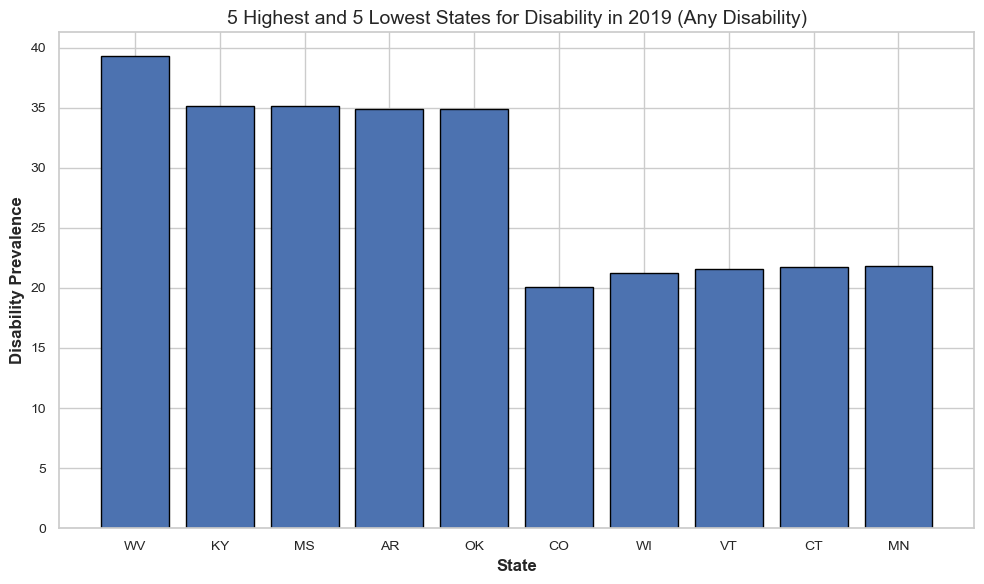

In [24]:
states = [
    "AL",
    "AK",
    "AZ",
    "AR",
    "CA",
    "CO",
    "CT",
    "DE",
    "FL",
    "GA",
    "HI",
    "ID",
    "IL",
    "IN",
    "IA",
    "KS",
    "KY",
    "LA",
    "ME",
    "MD",
    "MA",
    "MI",
    "MN",
    "MS",
    "MO",
    "MT",
    "NE",
    "NV",
    "NH",
    "NJ",
    "NM",
    "NY",
    "NC",
    "ND",
    "OH",
    "OK",
    "OR",
    "PA",
    "RI",
    "SC",
    "SD",
    "TN",
    "TX",
    "UT",
    "VT",
    "VA",
    "WA",
    "WV",
    "WI",
    "WY",
]

highest_lowest_states = disability_df[
    (disability_df["LocationAbbr"].isin(states))
    & (disability_df["Year"] == "2019")
    & (disability_df["Question"] == "Any Disability")
]

state_data = (
    highest_lowest_states.groupby("LocationAbbr")["DataValue"].sum().reset_index()
)

top_5_states = state_data.nlargest(5, "DataValue")
bottom_5_states = state_data.nsmallest(5, "DataValue")

selected_states = pd.concat([top_5_states, bottom_5_states])

plt.figure(figsize=(10, 6))
plt.bar(
    selected_states["LocationAbbr"], selected_states["DataValue"], edgecolor="black"
)
plt.title(
    "5 Highest and 5 Lowest States for Disability in 2019 (Any Disability)", fontsize=14
)
plt.xlabel("State", fontsize=12)
plt.ylabel("Disability Prevalence", fontsize=12)
plt.xticks(fontsize=10)
plt.yticks(fontsize=10)
plt.tight_layout()
plt.show()

The bar chart shows the 5 states with the highest and lowest disability prevalence in 2019 for individuals reporting any disability. The chart reveals the following:

- West Virginia (WV) has the highest disability prevalence among the states, with Kentucky (KY), Mississippi (MS), Arkansas (AR), and Oklahoma (OK) also reporting high disability rates.

- On the other end, Colorado (CO), Wisconsin (WI), Vermont (VT), Connecticut (CT), and Minnesota (MN) have the lowest disability prevalence.

This distribution indicates regional differences in disability rates, which could be influenced by factors such as healthcare access, socioeconomic status, or population demographics. Understanding these disparities is important when considering the potential impact of external factors, such as the COVID-19 pandemic, on disability rates across the country.


### 20. Top 5 states with biggest change

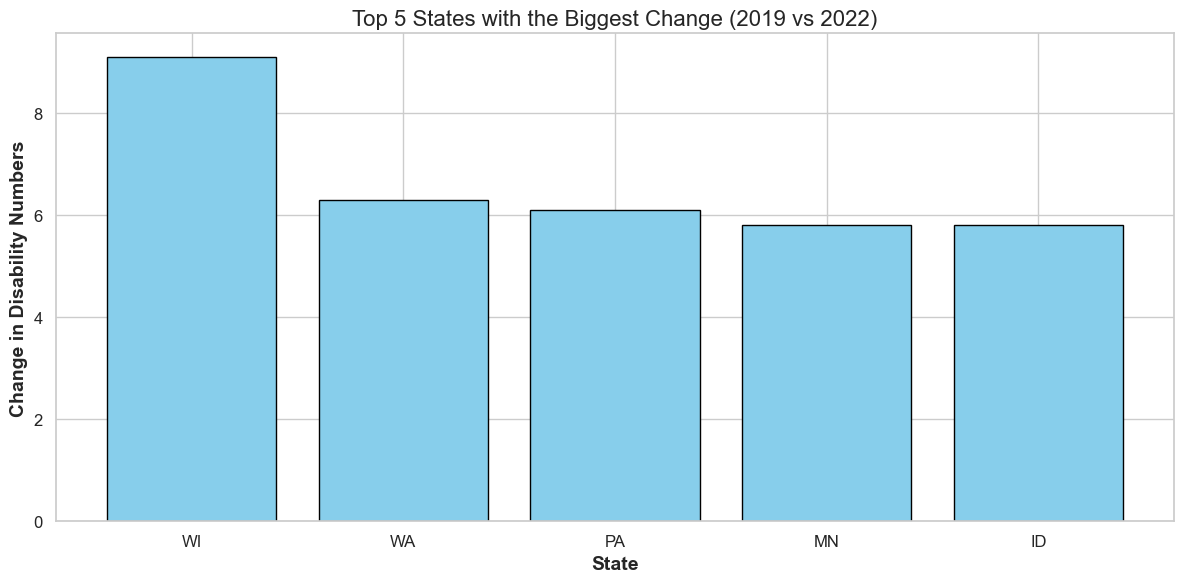

In [25]:
pre_covid_2019 = disability_df[
    (disability_df["Year"] == "2019") & (disability_df["LocationAbbr"].isin(states))
]
post_covid_2022 = disability_df[
    (disability_df["Year"] == "2022") & (disability_df["LocationAbbr"].isin(states))
]

pre_covid_2019_total = (
    pre_covid_2019.groupby("LocationAbbr")["DataValue"].sum().reset_index()
)
post_covid_2022_total = (
    post_covid_2022.groupby("LocationAbbr")["DataValue"].sum().reset_index()
)

merged_data = pd.merge(
    pre_covid_2019_total,
    post_covid_2022_total,
    on="LocationAbbr",
    suffixes=("_2019", "_2022"),
)

merged_data["Change"] = merged_data["DataValue_2022"] - merged_data["DataValue_2019"]

top_5_change = merged_data.sort_values("Change", ascending=False).head(5)

plt.figure(figsize=(12, 6))

plt.bar(
    top_5_change["LocationAbbr"],
    top_5_change["Change"],
    color="skyblue",
    edgecolor="black",
)

plt.xlabel("State", fontsize=14)
plt.ylabel("Change in Disability Numbers", fontsize=14)
plt.title("Top 5 States with the Biggest Change (2019 vs 2022)", fontsize=16)

plt.xticks(fontsize=12)
plt.yticks(fontsize=12)
plt.tight_layout()

plt.show()

The bar chart shows the Top 5 States with the Biggest Change in Disability Numbers between 2019 and 2022. It illustrates how the total number of individuals with disabilities has changed over this period. Wisconsin (WI) saw the largest increase in disability numbers, followed by Washington (WA), Pennsylvania (PA), Idaho (ID), and Minnesota (MN). The chart highlights states where the growth in disability numbers has been most pronounced, potentially reflecting the long-term effects of COVID-19 or other health-related factors influencing disability rates. This change in disability prevalence may point to ongoing health challenges, including those associated with the pandemic's aftermath.

### 21. Disability Rates by State in 2019

In [ ]:
pass

The map of disability rates in 2019 reveals a striking regional disparity, with states in and around Appalachia—such as West Virginia, Kentucky, Missouri, Oklahoma, North Carolina, and Alabama—exhibiting significantly higher rates of disability compared to the national average. While most of the country sees disability rates hover below 28%, this Appalachian and adjacent region reports rates between 33% and 40%. This disparity could be attributed to several socioeconomic and environmental factors. Appalachia has long faced economic challenges, including higher poverty rates, limited access to healthcare, and fewer employment opportunities, all of which can contribute to chronic health conditions and disabilities. Additionally, the prevalence of industries like coal mining, historically a major economic driver in the region, has likely exposed populations to physically demanding labor and workplace hazards, further exacerbating health issues. These structural inequities and environmental factors create a clear correlation between geography and disability prevalence in the United States.

### 22. Disability Rate Changes in the US: Pre & Post-COVID Analysis

In [ ]:
pass

This map visualizes the shifts in disability rates across the United States from 2018 to 2022, focusing on the period before and after the onset of COVID-19.

Before 2020, states like Montana, Nevada, North Carolina, New Hampshire, and Maine experienced a disability rate change of over 10%. However, post-2020, many of these states experienced a notable reduction in the rate of change, with most falling below 10%. This decline may be attributed to a variety of factors including underreporting of disabilities during the pandemic, changes in reporting practices, or the disproportionate effects of COVID-19, particularly death and long-term illness, skewing data. Interestingly, Illinois, New Hampshire, and Alaska exhibit a rise in disability rates of more than 20% after 2020.

These changes may be attributed to a variety of factors including underreporting of disabilities during the pandemic, changes in reporting practices, or the disproportionate effects of COVID-19, particularly death and long-term illness, skewing data.

The findings highlight the complexity of using disability rates as a measure for understanding the direct impacts of COVID-19. While the disability rate changes provide useful insights, they do not follow a clear, uniform pattern across states, suggesting that COVID-19’s effects on disability rates are multifaceted and shaped by a variety of factors, including healthcare disparities, reporting challenges, and varying state-level responses to the pandemic.